**What** : Exploratory data analysis of loan data.

**Why**  : Identify how the consumer and loan attributes influence the tendancy of an applicant borrower to default.

# Data loading

In [1]:
# import statements
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Load the data into the data frame using pandas

In [2]:
df=pd.read_csv('loan.csv')
df.columns = df.columns.str.strip()

Investigate if data loaded properly

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Check the shape to identify record and field counts

In [4]:
df.shape

(39717, 111)

Load the data dictionary

In [5]:
#load the data dictionary and check if the data loaded correctly
ddf=pd.read_csv('Data_Dictionary.csv')
ddf['LoanStatNew'] = ddf['LoanStatNew'].apply(lambda x: x.strip())
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LoanStatNew  115 non-null    object
 1   Description  115 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB


In [6]:
ddf.shape

(115, 2)

In [7]:
ddf.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


The number of fields in the loans data frame is not matching with the Data_Dictionary. 111 to 115, identify the fields that are not present to check its significance/impact on the our analysis.

Load the columns of the loans data frame into its own dataframe

In [8]:
colFrame = { 'LoanStatNew': df.columns, 'IsPresent':[True] * df.columns.shape[0]  }
colDf = pd.DataFrame(colFrame)
colDf.head()

,LoanStatNew,IsPresent
0,id,True
1,member_id,True
2,loan_amnt,True
3,funded_amnt,True
4,funded_amnt_inv,True


The data dict frame has more records so a left join with the loans column dataframe and a filter on null will list the missing fields.

In [9]:
merged=ddf.merge(colDf,how='left',on='LoanStatNew')
merged[merged.IsPresent.isnull()]

,LoanStatNew,Description,IsPresent
21,fico_range_high,The upper boundary range the borrower’s FICO a...,NaN
22,fico_range_low,The lower boundary range the borrower’s FICO a...,NaN
37,last_fico_range_high,The upper boundary range the borrower’s last F...,NaN
38,last_fico_range_low,The lower boundary range the borrower’s last F...,NaN
113,verified_status_joint,Indicates if the co-borrowers' joint income wa...,NaN


In [10]:
merged1=ddf.merge(colDf,how='right',on='LoanStatNew')
merged1[merged1.Description.isnull()]

,LoanStatNew,Description,IsPresent
55,verification_status_joint,NaN,True


In [11]:
df['verification_status_joint'].isnull().sum()

39717

1.   FICO is a credit score created by Fair Isaac Corporation, The actual dataset does not contain these fields. Proceeding with analysis without this data.

2. verified_status_joint field which describes the verification status of income concerning co-borrowers is present in our dataset as verification_status_joint. Data in this field is all NA so we will drop this field in cleanup steps.

# Data cleaning

Agenda: Identify fields that have null value or have incorrect data types. Drop, fix or impute the value

In [12]:
df.info(verbose=True,show_counts=True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

## Bulk analysis of data issues and cleanup.

Get all the column names where the fields do not have a single non null value. Drop these fields from the frame.

In [13]:
for c in df.columns:
  if df[c].isnull().sum()==df.shape[0]:
    print(f"'{c}',")

'mths_since_last_major_derog',
'annual_inc_joint',
'dti_joint',
'verification_status_joint',
'tot_coll_amt',
'tot_cur_bal',
'open_acc_6m',
'open_il_6m',
'open_il_12m',
'open_il_24m',
'mths_since_rcnt_il',
'total_bal_il',
'il_util',
'open_rv_12m',
'open_rv_24m',
'max_bal_bc',
'all_util',
'total_rev_hi_lim',
'inq_fi',
'total_cu_tl',
'inq_last_12m',
'acc_open_past_24mths',
'avg_cur_bal',
'bc_open_to_buy',
'bc_util',
'mo_sin_old_il_acct',
'mo_sin_old_rev_tl_op',
'mo_sin_rcnt_rev_tl_op',
'mo_sin_rcnt_tl',
'mort_acc',
'mths_since_recent_bc',
'mths_since_recent_bc_dlq',
'mths_since_recent_inq',
'mths_since_recent_revol_delinq',
'num_accts_ever_120_pd',
'num_actv_bc_tl',
'num_actv_rev_tl',
'num_bc_sats',
'num_bc_tl',
'num_il_tl',
'num_op_rev_tl',
'num_rev_accts',
'num_rev_tl_bal_gt_0',
'num_sats',
'num_tl_120dpd_2m',
'num_tl_30dpd',
'num_tl_90g_dpd_24m',
'num_tl_op_past_12m',
'pct_tl_nvr_dlq',
'percent_bc_gt_75',
'tot_hi_cred_lim',
'total_bal_ex_mort',
'total_bc_limit',
'total_il_high_credit_l

In [14]:
df.drop(['annual_inc_joint',
'dti_joint',
'verification_status_joint',
'tot_coll_amt',
'tot_cur_bal',
'open_acc_6m',
'open_il_6m',
'open_il_12m',
'open_il_24m',
'mths_since_rcnt_il',
'total_bal_il',
'il_util',
'open_rv_12m',
'open_rv_24m',
'max_bal_bc',
'all_util',
'total_rev_hi_lim',
'inq_fi',
'total_cu_tl',
'inq_last_12m',
'acc_open_past_24mths',
'avg_cur_bal',
'bc_open_to_buy',
'bc_util',
'mo_sin_old_il_acct',
'mo_sin_old_rev_tl_op',
'mo_sin_rcnt_rev_tl_op',
'mo_sin_rcnt_tl',
'mort_acc',
'mths_since_recent_bc',
'mths_since_recent_bc_dlq',
'mths_since_recent_inq',
'mths_since_recent_revol_delinq',
'num_accts_ever_120_pd',
'num_actv_bc_tl',
'num_actv_rev_tl',
'num_bc_sats',
'num_bc_tl',
'num_il_tl',
'num_op_rev_tl',
'num_rev_accts',
'num_rev_tl_bal_gt_0',
'num_sats',
'num_tl_120dpd_2m',
'num_tl_30dpd',
'num_tl_90g_dpd_24m',
'num_tl_op_past_12m',
'pct_tl_nvr_dlq',
'percent_bc_gt_75',
'tot_hi_cred_lim',
'total_bal_ex_mort',
'total_bc_limit',
'total_il_high_credit_limit'],axis=1,inplace=True)

loop through each field and try to check if there are any fields with less than 5 unique values. This helps identify coulmns which have same data throughout.

In [15]:
for c in df.columns:
  x=df[c].nunique()
  if x<= 5:
    print(f'{c}:{x}:{df[c].unique()}')

term:2:[' 36 months' ' 60 months']
home_ownership:5:['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
verification_status:3:['Verified' 'Source Verified' 'Not Verified']
loan_status:3:['Fully Paid' 'Charged Off' 'Current']
pymnt_plan:1:['n']
pub_rec:5:[0 1 2 3 4]
initial_list_status:1:['f']
next_pymnt_d:2:[nan 'Jun-16' 'Jul-16']
collections_12_mths_ex_med:1:[ 0. nan]
mths_since_last_major_derog:0:[nan]
policy_code:1:[1]
application_type:1:['INDIVIDUAL']
acc_now_delinq:1:[0]
chargeoff_within_12_mths:1:[ 0. nan]
delinq_amnt:1:[0]
pub_rec_bankruptcies:3:[ 0.  1.  2. nan]
tax_liens:1:[ 0. nan]


drop fields with only 1 value

In [16]:
df.drop(['pymnt_plan','initial_list_status','policy_code','application_type','acc_now_delinq','delinq_amnt','tax_liens','chargeoff_within_12_mths'],axis=1,inplace=True)

Insight:  Loan status has 3 categories 'Fully Paid, Charged Off, Current'. This is the field used to verify defaults. Current category is for borrowers who have already secured a loan and have neither fully paid or defaulted. No point in keeping these records for our problem statement. Drop these records

In [17]:
df=df[~(df.loan_status=='Current')]

Basic cleanup of data is complete. Perform additional analysis as to how many of these fields makes sense to be retained for analysis

In [18]:
df['title'].value_counts()

Debt Consolidation           2090
Debt Consolidation Loan      1620
Personal Loan                 641
Consolidation                 491
debt consolidation            478
                             ... 
Murray Loan                     1
Need debt consolidation!        1
freedom2                        1
DAVE WEDDING                    1
JAL Loan                        1
Name: title, Length: 19297, dtype: int64

In [19]:
df['purpose'].value_counts()

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64

Fields such as URL has no major use in our analysis and fields such as Desc , Title etc can be better analyzed using purpose field. The data in them is similar to purpose but data in field **purpose** is much cleaner and usable.

It is evident at first glance that the fields **id** and **member_id** are specific to an individual. It does not have significance in our analysis to predict chargeoff criteria.

Drop these fields.



In [20]:
df.drop(['url','desc','title'],axis=1,inplace=True)

### Identify fields for cleanup at individual level

Define reusable methods for IQR

In [21]:
def iqr(x):
  return x.quantile(0.75)-x.quantile(0.25)

def iqrUpperOutlier(x):
  return x.quantile(0.75)+(1.5*iqr(x))

def iqrLowerOutlier(x):
  return x.quantile(0.25)-(1.5*iqr(x))

Agenda: Identify remaining null value fields, fields with object as type and fields with outliers

Fields with null values

In [22]:
for x in df.columns:
  nval=df[x].isnull().sum()
  if nval>0:
    print(x)

emp_title
emp_length
mths_since_last_delinq
mths_since_last_record
revol_util
last_pymnt_d
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
pub_rec_bankruptcies


Fields with data type issues

In [23]:
df.select_dtypes(include=['object']).columns

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util',
       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

Fields int_rate, emp_length, issue_d,earliest_cr_line, revol_util,last_pymnt_d
next_pymnt_d,last_credit_pull_d seems to have incorrect types. These will be considered one by one for data type fix. Upon completion of data type fix, if it is found to be a numeric type, we will check for outliers

## Clean the employee title field

Field depicts the employment title of the borrower

In [24]:
df['emp_title'].isnull().sum()

2386

There are 2459 null records

In [25]:
df['emp_title'].nunique()

28027

In [26]:
df['emp_title'].value_counts(normalize=True, dropna=False)

NaN                                         0.061850
US Army                                     0.003396
Bank of America                             0.002774
IBM                                         0.001685
AT&T                                        0.001478
                                              ...   
Net Equity Financial                        0.000026
Kernersville Fire Department                0.000026
The Keith Corp. (empl by county, now Kei    0.000026
Bertie Middle School                        0.000026
Evergreen Center                            0.000026
Name: emp_title, Length: 28028, dtype: float64

6% of the overall data is null and we have 28820 unique values for a categorical variable. Drop the field

In [27]:
df.drop('emp_title',axis=1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,0.00,0.00,0.00,Jan-15,161.03,NaN,Jan-16,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,...,0.00,0.00,0.00,Jul-10,80.90,NaN,Jun-10,NaN,NaN,NaN
39713,90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,...,0.00,0.00,0.00,Jul-10,281.94,NaN,Jul-10,NaN,NaN,NaN
39714,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,0.00,0.00,0.00,Apr-08,0.00,NaN,Jun-07,NaN,NaN,NaN
39715,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,0.00,0.00,0.00,Jan-08,0.00,NaN,Jun-07,NaN,NaN,NaN


## Clean the emp_length field

As per the data dictionary, this field depicts the length of employment of the borrower. This is a significant borower property that we will analyze for 

In [28]:
df['emp_length'].isnull().sum()

1033

In [29]:
df['emp_length'].value_counts(normalize=True, dropna=False)

10+ years    0.220027
< 1 year     0.116857
2 years      0.111232
3 years      0.104000
4 years      0.086632
5 years      0.082795
1 year       0.082147
6 years      0.056199
7 years      0.044353
8 years      0.037198
9 years      0.031781
NaN          0.026778
Name: emp_length, dtype: float64

Dropping the NaN records as it is around 3% of records

In [30]:
df=df[~df['emp_length'].isnull()]

In [31]:
df['emp_length'].value_counts(dropna=False)

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

Convert the employment length to numerical variable. Remove special characters such as + < and years from the field.

In [32]:
def employeelength_cleanup(length):
  length=length.replace('years','').replace('year','').replace('+','')
  if('<' in length):
    length='0'
  return int(length)
df['emp_length']=df['emp_length'].apply(employeelength_cleanup)

In [33]:
df['emp_length'].value_counts(dropna=False)

10    8488
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: emp_length, dtype: int64

## Clean the mths_since_last_delinq field

 This field describes the number of months since the borrower's last delinquency.  Retaining it for general analytics outside purview of problem statement

In [34]:
df['mths_since_last_delinq'].isnull().sum()

24206

In [35]:
df['mths_since_last_delinq'].nunique()

95

In [36]:
df['mths_since_last_delinq'].value_counts(normalize=True)

0.0      0.033213
15.0     0.017919
30.0     0.017844
23.0     0.017544
24.0     0.017169
           ...   
107.0    0.000075
85.0     0.000075
97.0     0.000075
95.0     0.000075
96.0     0.000075
Name: mths_since_last_delinq, Length: 95, dtype: float64

mths_since_last_delinq. It signifies how many months have passed since the last time a payment was defaulted. No point in using this field for analysis as it has 24952 missing values and depicts a post default data. Drop the column.

In [37]:
df.drop('mths_since_last_delinq',axis=1,inplace=True)

In [38]:
df.shape

(37544, 46)

## Clean the mths_since_last_major_derog field

 It depicts the months since most recent worse rating 

In [39]:
df['mths_since_last_major_derog'].isnull().sum()

37544

38642 records in this field have no values. drop this field.

In [40]:
df.drop('mths_since_last_major_derog',axis=1,inplace=True)

## Clean the mths_since_last_record field

Depicts The number of months since the last public record.

In [41]:
df['mths_since_last_record'].isnull().sum()

34923

In [42]:
df['mths_since_last_record'].nunique()

111

In [43]:
df['mths_since_last_record'].value_counts()

0.0      670
104.0     58
111.0     56
113.0     55
89.0      55
        ... 
14.0       1
7.0        1
19.0       1
46.0       1
5.0        1
Name: mths_since_last_record, Length: 111, dtype: int64

35979 have null value, drop the field

In [44]:
df.drop('mths_since_last_record',axis=1,inplace=True)

## Clean the revol_util field

Field depicts the amount of credit the borrower is using relative to all available revolving credit. Example: Percentage of credit utilized to max credit limit set in a credit card account. This field is a post loan disbursment variable. Retaining it for general analytics outside purview of problem statement

In [45]:
df['revol_util'].isnull().sum()

47

Removing the 47 records 

In [46]:
df= df[~df['revol_util'].isnull()]

Fix the data type of the field by removing the %

In [47]:
df['revol_util']=df['revol_util'].apply(lambda a: float(str(a).replace('%','')))

## Clean the last_pymnt_d field

The field depicts the month when last payment was received. Probably we can get some insigths regarding how many months the borrower made payments by comparing with issue_d field. Field insights are to be considered outside problem statement

In [48]:
df['last_pymnt_d'].isnull().sum()

62

Around 66 records do not have last payment received month. Drop these records

In [49]:
df=df[~df['last_pymnt_d'].isnull()]

Convert the field to date time, challenge is to use the proper format

In [50]:
df['last_pymnt_d']=pd.to_datetime(df['last_pymnt_d'],format='%b-%d')

In [51]:
df['last_pymnt_d'].nunique()

101

In [52]:
df['last_pymnt_d'].value_counts()

1900-03-13    999
1900-12-14    910
1900-05-13    884
1900-02-13    845
1900-03-12    827
             ... 
1900-06-08     10
1900-11-08     10
1900-03-08      5
1900-01-08      4
1900-02-08      1
Name: last_pymnt_d, Length: 101, dtype: int64

Derive month and day fields for the last payment received.

In [53]:
df['last_payment_month']=df['last_pymnt_d'].dt.month
df['last_payment_day']=df['last_pymnt_d'].dt.day


## Clean the next_pymnt_d field

Field depicts the next payment due date.

In [54]:
df['next_pymnt_d'].isnull().sum()

37435

The data for 37478 is null. Usually the loan repayment is on a monthly interval. We should try and impute data based on last_payment_d + 1 month. Before that convert the type to datetime

In [55]:
df['next_pymnt_d']=pd.to_datetime(df['next_pymnt_d'],format='%d-%b')

In [56]:
(df['next_pymnt_d']-df['last_pymnt_d']).value_counts()

Series([], dtype: int64)

Looks like majority of the terms are on monthly. We can consider the interval as 31 days and update the data using 
**df.loc[df['next_pymnt_d'].isnull(),'next_pymnt_d']= df['last_pymnt_d']+ pd.Timedelta(days=31)**

If we proceed with 31 days, we will introduce a bias as this inference is obtained using 1038 records. Dropping the field.

In [57]:
df.drop('next_pymnt_d',axis=1,inplace=True)

Remove the original column as the year is inaccurate for last payment date

In [58]:
df.drop('last_pymnt_d',axis=1,inplace=True)

## Clean the last_credit_pull_d field

Depicts the most recent month Lending Club pulled credit report for this loan.Field insights are to be considered outside problem statement

In [59]:
df['last_credit_pull_d'].nunique()

106

In [60]:
df['last_credit_pull_d'].value_counts()

May-16    9098
Apr-16    2326
Mar-16    1093
Feb-13     831
Feb-16     711
          ... 
May-07       1
Jun-08       1
Jul-08       1
May-08       1
Jul-07       1
Name: last_credit_pull_d, Length: 106, dtype: int64

In [61]:
df['last_credit_pull_d'].isnull().sum()

2

Drop the 2 records

In [62]:
df=df[~df['last_credit_pull_d'].isnull()]

Change the data type to date time.

In [63]:
df['last_credit_pull_d']=pd.to_datetime(df['last_credit_pull_d'],format='%b-%d')

Derive month and day fields for the last credit pull date.

In [64]:
df['last_credit_pull_month']=df['last_credit_pull_d'].dt.month
df['last_credit_pull_day']=df['last_credit_pull_d'].dt.day

drop the last_credit_pull_d field as the year is inaccurate

In [65]:
df.drop('last_credit_pull_d',axis=1,inplace=True)

## Clean the collections_12_mths_ex_med field

Number of collections/re-payment received in 12 months excluding medical.

In [66]:
df['collections_12_mths_ex_med'].isnull().sum()

56

In [67]:
df['collections_12_mths_ex_med'].value_counts()

0.0    37377
Name: collections_12_mths_ex_med, dtype: int64

All of the values are 0. Drop this field.

In [68]:
df.drop('collections_12_mths_ex_med',axis=1,inplace=True)

## Clean the int_rate field

The interest rate at which the loan was offered.

In [69]:
df['int_rate'].value_counts()

10.99%    891
11.49%    762
7.51%     755
13.49%    734
7.88%     701
         ... 
16.33%      1
16.15%      1
16.01%      1
10.64%      1
16.20%      1
Name: int_rate, Length: 370, dtype: int64

Change the interest rate field to float by removing the % character in the rows. Using comprehension instead of lambda

In [70]:
df['int_rate']=[float(x.replace('%','')) for x in df['int_rate']]

## Clean the pub_rec_bankruptcies field

This field describes number of times the borrower filed for bankruptcy.

In [71]:
df['pub_rec_bankruptcies'].isnull().sum()

696

696 fields is a small percentage of the overall data. Attempt imputing data

In [72]:
df['pub_rec_bankruptcies'].nunique()

3

In [73]:
df['pub_rec_bankruptcies'].value_counts()

0.0    35209
1.0     1523
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

In [74]:
df['pub_rec_bankruptcies'].mode()

0    0.0
Name: pub_rec_bankruptcies, dtype: float64

In [75]:
df['pub_rec_bankruptcies'].describe()

count    36737.000000
mean         0.041729
std          0.200652
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

The mode is 0, majority of the values in this field is 0.Median is 0, mean is close to 0. Imputing the data with 0

In [76]:
# using fillna instead of loc for demonstration
df['pub_rec_bankruptcies'].fillna(0.0, inplace= True)

## Clean the earliest_cr_line field

The field describes the month the most earliest credit line was offered. 1st credit card swipe/loan provided?

In [77]:
df['earliest_cr_line'].isnull().sum()

0

In [78]:
df['earliest_cr_line'].nunique()

514

In [79]:
df['earliest_cr_line'].value_counts()

Oct-99    355
Nov-98    353
Dec-98    332
Oct-00    330
Nov-00    309
         ... 
Feb-73      1
Dec-65      1
Oct-70      1
Nov-72      1
Sep-63      1
Name: earliest_cr_line, Length: 514, dtype: int64

In [80]:
df[['earliest_cr_line']]

,earliest_cr_line
0,Jan-85
1,Apr-99
2,Nov-01
3,Feb-96
5,Nov-04
...,...
39712,Nov-90
39713,Dec-86
39714,Oct-98
39715,Nov-88


The data seems to be in multiple formats. We have Jan-85 and 1-Nov. We need to do some advanced cleaning on this field. We could drop this field or use it for analysis such as how length of association of the customer affects the loan status. We shall consider cleaning this in our analysis

In [81]:
(df['earliest_cr_line'].map(lambda x:x.split('-')[0].isnumeric())==True).sum()

0

Lets assume that the for the records where the year is not provided, we will consider it to be current year, day will be 1st of the month. Data dictionary mentions the month borrower's earliest reported credit line was opened, so only month is to be considered accurate, year and day to be ignored during analysis

In [82]:
df['earliest_cr_line']=df['earliest_cr_line'].apply(lambda x: f"{x.split('-')[1].strip()}-2022" if x.split('-')[0].isnumeric() else f"{x.split('-')[0].strip()}-19{x.split('-')[1].strip()}")

Convert the field to datetime

In [83]:
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'])

## Clean the issue_d field

The month in which the current loan was funded

In [84]:
df['issue_d'].isnull().sum()

0

In [85]:
df['issue_d'].nunique()

55

In [86]:
df['issue_d'].value_counts()

Dec-11    1993
Nov-11    1966
Oct-11    1858
Sep-11    1831
Aug-11    1750
Jun-11    1671
Jul-11    1666
May-11    1551
Apr-11    1503
Mar-11    1395
Jan-11    1336
Feb-11    1239
Dec-10    1219
Nov-10    1095
Jul-10    1090
Oct-10    1080
Sep-10    1056
Aug-10    1053
Jun-10     991
May-10     892
Apr-10     805
Mar-10     716
Feb-10     601
Nov-09     597
Dec-09     595
Jan-10     581
Oct-09     543
Sep-09     447
Aug-09     408
Jul-09     372
Jun-09     353
May-09     319
Apr-09     287
Mar-09     275
Feb-09     259
Jan-09     236
Mar-08     232
Dec-08     222
Nov-08     183
Feb-08     174
Jan-08     171
Apr-08     155
Oct-08      96
Dec-07      84
Jul-08      82
May-08      71
Aug-08      70
Jun-08      66
Oct-07      47
Nov-07      37
Aug-07      33
Sep-08      32
Jul-07      30
Sep-07      18
Jun-07       1
Name: issue_d, dtype: int64

In [87]:
df['issue_d']=pd.to_datetime(df['issue_d'],format='%b-%d')

In [88]:
df['issue_d']

0       1900-12-11
1       1900-12-11
2       1900-12-11
3       1900-12-11
5       1900-12-11
           ...    
39712   1900-07-07
39713   1900-07-07
39714   1900-07-07
39715   1900-07-07
39716   1900-06-07
Name: issue_d, Length: 37433, dtype: datetime64[ns]

In [89]:
df['issue_d_month']=df['issue_d'].dt.month
df['issue_d_day']=df['issue_d'].dt.day

In [90]:
df.drop('issue_d',axis=1,inplace=True)

## Outlier Handling

Identify the fields with outliers. In general, if the type is numeric, we shall check for outliers using 1.5 IQR method. Basically, any record greater than 1.5 IQR of Q3 or less than 1.5 IQR of Q1 will be dropped

In [91]:
for x in df.select_dtypes(include=['int64','float64']).columns:  
  if (df[(df[x] > iqrLowerOutlier(df[x])) & (df[x]< iqrUpperOutlier(df[x]))]).shape[0]<df.shape[0]:
    print(x)    

member_id
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
pub_rec_bankruptcies
last_payment_day
last_credit_pull_day
issue_d_day


Out of these fields, only below ones are pre disbursement usable attributes. Only these will be considered for outlier removal
1.   loan_amnt
2.   funded_amnt
4.   annual_inc
5.   int_rate


### loan_amnt

<AxesSubplot:>

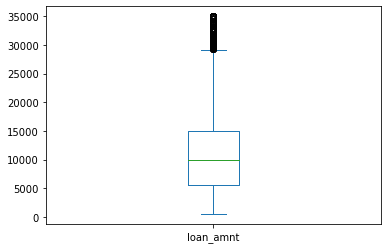

In [92]:
df.loan_amnt.plot.box()

outliers are detected in the box plot. Drop the outliers

In [93]:
df=df[(df.loan_amnt > iqrLowerOutlier(df.loan_amnt)) & (df.loan_amnt< iqrUpperOutlier(df.loan_amnt))]

### funded_amnt

<AxesSubplot:>

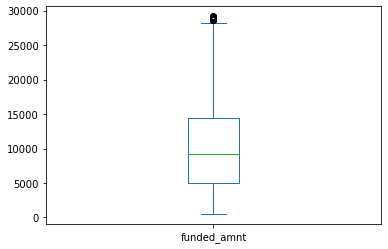

In [94]:
df.funded_amnt.plot.box()

outliers are detected in the box plot. Drop the outliers

In [95]:
df=df[(df.funded_amnt > iqrLowerOutlier(df.funded_amnt)) & (df.funded_amnt< iqrUpperOutlier(df.funded_amnt))]

### int_rate

Check for outliers. We shall consider 1.5 * IQR as outliers i.e 1.5 IQR above Q3 and below Q1

In [96]:
df=df[(df.int_rate > iqrLowerOutlier(df.int_rate)) & (df.int_rate< iqrUpperOutlier(df.int_rate))]

### annual income

In [97]:
df['annual_inc'].max()

6000000.0

max annual income is 6 million

In [98]:
df['annual_inc'].describe()

count    3.626300e+04
mean     6.774128e+04
std      6.343816e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.800000e+04
75%      8.000000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

<AxesSubplot:>

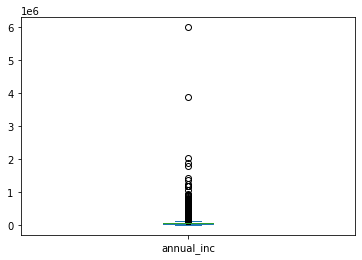

In [99]:
df['annual_inc'].plot.box()

Q3 is 0.8 million and max is 6 million and Box plot also shows outliers. Clean and remove the outliers

In [100]:
df=df[(df.annual_inc > iqrLowerOutlier(df.annual_inc)) & (df.annual_inc< iqrUpperOutlier(df.annual_inc))]

#Data analysis

Out of the remaining fields in the data set post cleanup and further analysis of the data dictionary, we find these fields to be interesting with respect to determining default for an applicant. We shall perform analysis of these in this section. LC recommendations will be based on this analysis

1.   Loan amount
2.   Funded amount
3.   Term
4.   Verification Status
5.   Interest rate
6.   Grade
7.   Sub-Grade
8.   Employment length
9.   Home ownership
10.  Annual income
11.  Purpose
12.  State
13.  Loan to income ratio
14.  Loan issue month



### loan amount

numerical variable : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [101]:
df.loan_amnt.describe()

count    34487.000000
mean     10203.097544
std       6219.778213
min        500.000000
25%       5000.000000
50%       9000.000000
75%      14125.000000
max      29000.000000
Name: loan_amnt, dtype: float64

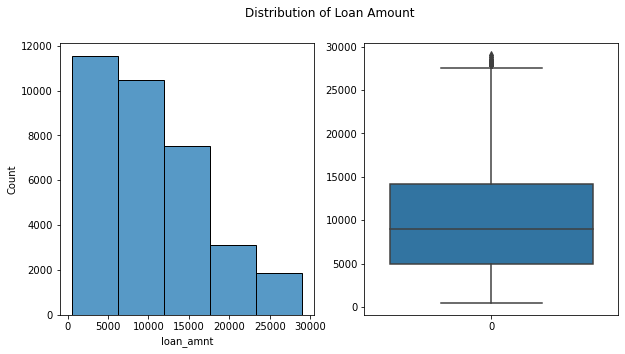

In [102]:
def plotUnivariateAnalysis(col,title,bin=5,width=10,height=5):
  # ?plt.subplot takes 3 params number of rows, number of columns and index.
  plt.figure(figsize=(width,height))
  plt.subplot(1,2,1)
  #Plot a histogram
  sns.histplot(data=df[col],bins=bin)
  plt.subplot(1,2,2)
  #plot a box plot
  sns.boxplot(data=df[col])
  plt.suptitle(title)
  plt.show()

plotUnivariateAnalysis('loan_amnt','Distribution of Loan Amount')

We will create reusable functions for analysis of multiple attributes. In subsequent attributes, we will use these functions directly

**Insights:**
1.   Hist plot shows that maximum number of borrowers opted loan amount upto 6000. This insight can be used by LC to provide attractive offers in that amount range.
2.   75% of borrowers opted for loan amount of 15k or below
3.   25% of borrowers opted for amount of 5k or below

In [103]:
iqr(df.loan_amnt)

9125.0

IQR for the loan amount is 9125

Bi-variate analysis with loan status

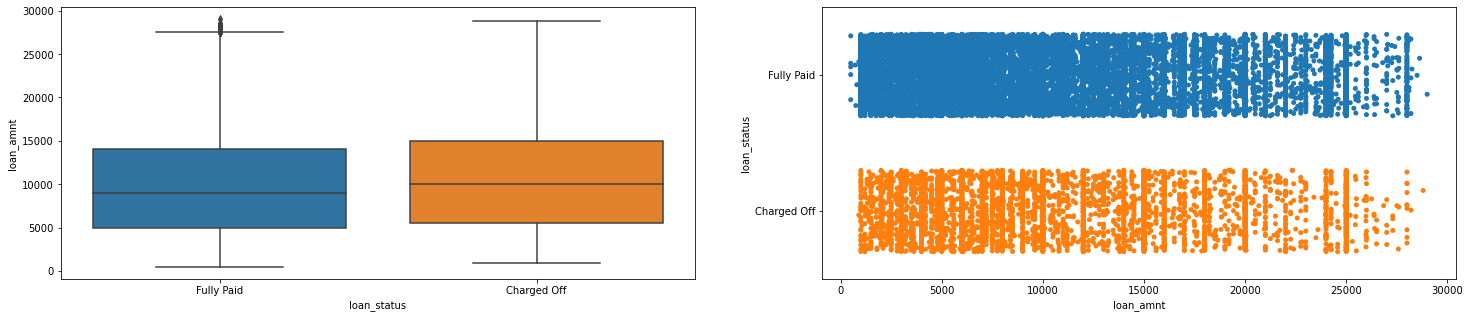

In [104]:
def plotSimpleBivariateAnalysis(col,width=15,height=5):
  fig=plt.figure(figsize=(width,height))
  ax=fig.add_subplot(121)
  #Plot a box plot
  sns.boxplot(x='loan_status',y=col,data=df,ax=ax)
  ax1=fig.add_subplot(122)
  #plot a strip plot
  sns.stripplot(data=df[[col,'loan_status']],y='loan_status',x=col,ax=ax1, jitter=0.3)    

plotSimpleBivariateAnalysis('loan_amnt',25)

Based on the box plots, we can observe that 
1.   25% of charged off loans were borrowers who applied for loan amount of 6000
2.   50% of charged off loans were borrowers who applied for loan amount of 11000
3.   75% of charged off loans were borrowers who applied for loan amount of 15000
4.   Strip plot shows trend that fully paid borrowers were densely populated near lower amounts i.e below 12000.
5.   Strip plot shows trend that at loan amounts that are whole numbers, chargeoff's were high. i.e multiples of 5000

Binned ratio based analysis of fully paid vs charged off loans

In [105]:
def createGroupAndPlotBar(col,bin):
  #https://pandas.pydata.org/docs/reference/api/pandas.cut.html
  # use the pandas cut api to split the numerical data into buckets/bins
  df[f'{col}_group'] = pd.cut(df[col], bins=bin,precision =0)
  # Calculate the ratio 
  z=df[[f'{col}_group','loan_status']].value_counts().reset_index(name='counts')
  y=df[f'{col}_group'].value_counts().reset_index(name='totals').rename(columns={'index': f'{col}_group'})
  x=z.merge(y, how='left',on=f'{col}_group',)
  x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)
  return x

In [106]:
def plotForFullyPaidVsChargeOff(x,col):
  plt.figure(figsize=(15,10))
  sns.barplot(x=f'{col}_group',y='ratio', data=x,hue='loan_status')
  plt.xticks(rotation=90)

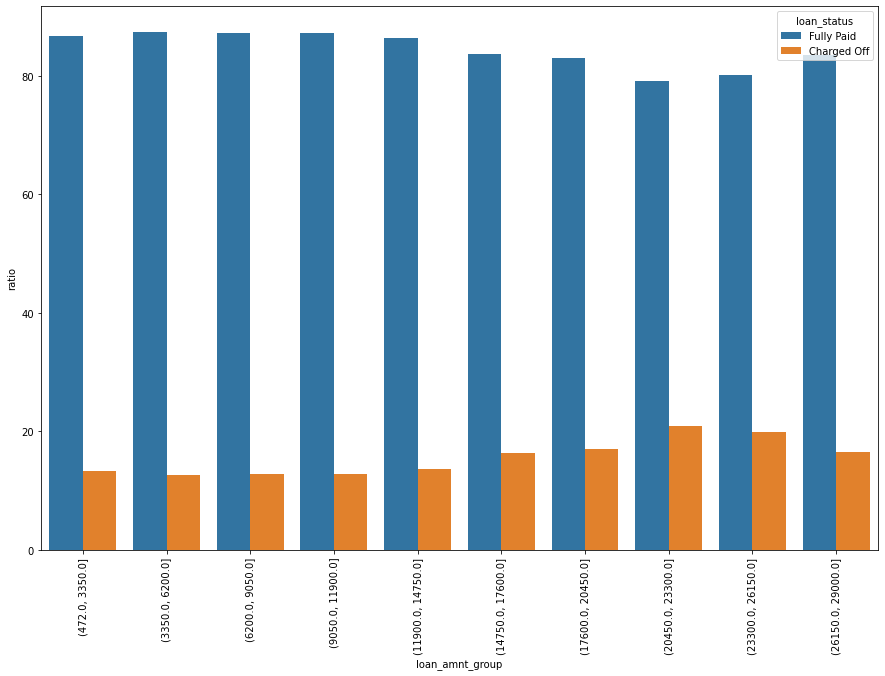

In [107]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('loan_amnt',10),'loan_amnt')

**Observation**: 

1. Trend observed is that as loan amount increased, the defaults increased.
2. Tendency to default was highest for loan amounts between 20000-26000




### funded_amnt

Numerical variable: Loan amount is requested amount by borrower. Lender need not disburse or sanction the complete amount. Funded amount is the amount lent by the lender

In [108]:
df['funded_amnt'].describe()

count    34487.000000
mean      9984.713805
std       6016.767237
min        500.000000
25%       5000.000000
50%       9000.000000
75%      14000.000000
max      28250.000000
Name: funded_amnt, dtype: float64

In [109]:
iqr(df.funded_amnt)

9000.0

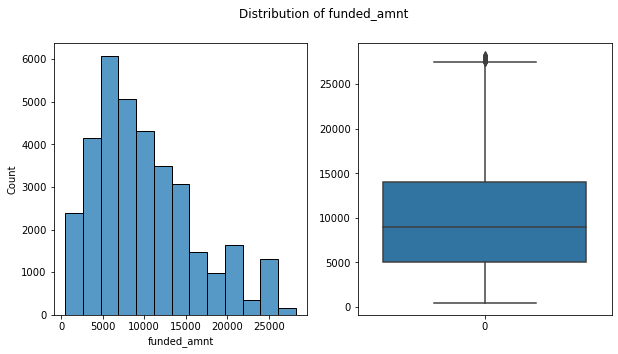

In [110]:
plotUnivariateAnalysis('funded_amnt','Distribution of funded_amnt',bin=13)


**Insights**
1.   75% of borrowers were funded upto 14000
2.   50% of borrowers were funded upto 10000
3.   25% of the borrowers were funded upto 5000
4.   Minimum amount funded was 500. Maximum amount funded was 28250
5.   Hist plot shows trend that maximum amount of borrowers were funded approximately 5000
6.  IQR is around 9000

Bi-variate analysis with loan status

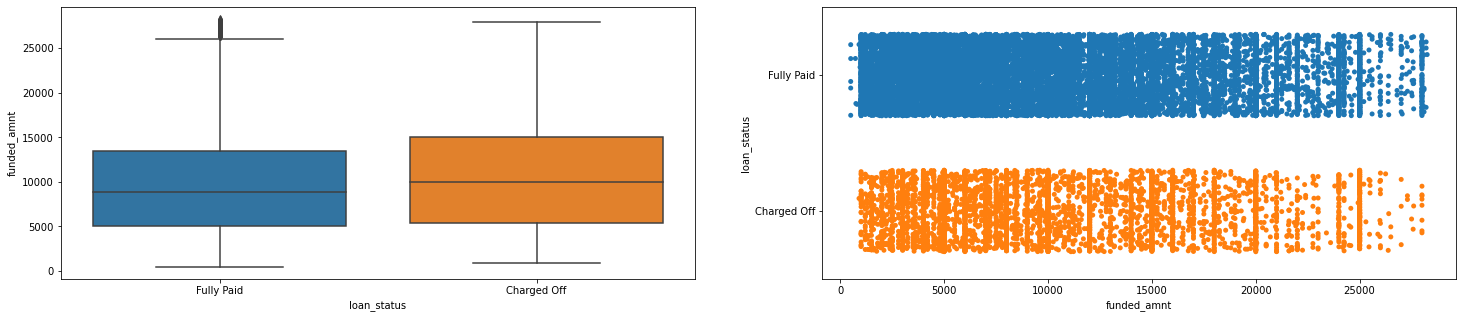

In [111]:
plotSimpleBivariateAnalysis('funded_amnt',25,5)

**Insights**
1.   75% of chargeoff was for funded amount 15000 and below
2.   50% of chargeoff was for funded amounts 10000 and below
3.   25% of chargeoff was for funded amounts 5000 and below
4.   Strip plot shows trend that fully paid borrowers were densely populated near lower funded amounts i.e below 12000.
5.   Strip plot shows trend that at funded amounts that are whole numbers, chargeoff's were high. i.e multiples of 5000


Binned ratio based analysis of fully paid vs charged off loans

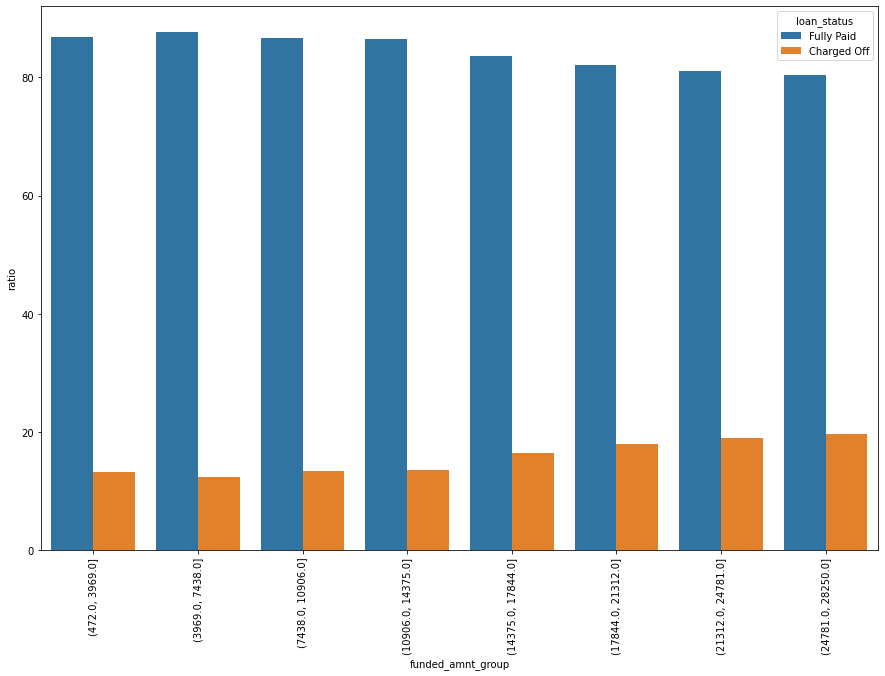

In [112]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('funded_amnt',8),'funded_amnt')

**Observation**
1. As funded amount increased, the charge off increased.

funded amount/loan amount should give the funded ratio. does this ratio provide insights to default

In [113]:
df['funded_ratio']=(df['funded_amnt']/df['loan_amnt'])*100

In [114]:
df.funded_ratio.describe()

count    34487.000000
mean        98.709015
std          6.715024
min         10.125000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: funded_ratio, dtype: float64

**Insights**
1.   75% of borrowers were funded 100% of the requested/sanctioned loan amount
2.   50% of borrowers were funded 100% of the requested/sanctioned loan amount
3.   25% of borrowers were funded 100% of the requested/sanctioned loan amount

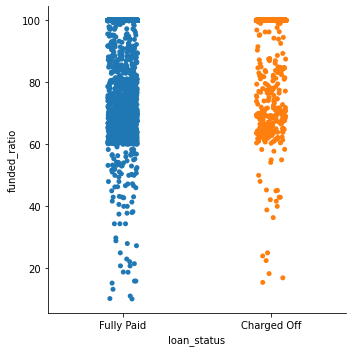

In [115]:
sns.catplot(x='loan_status',y='funded_ratio',data=df, hue='loan_status')

**Insights**
1. Cat plot shows trend that if funded amount was below 60% of loan amount requesed, charge off was less. 

funded amt to annual income and its impact to default. What percentage of the annual income of the borrower can be funded and what impact does it have on default

In [116]:
df['funded_to_annualinc_ratio']=(df.funded_amnt/df.annual_inc)*100

In [117]:
df.funded_to_annualinc_ratio.describe()

count    34487.000000
mean        18.219384
std         10.889697
min          0.737463
25%         10.000000
50%         16.184971
75%         24.390244
max         83.000000
Name: funded_to_annualinc_ratio, dtype: float64

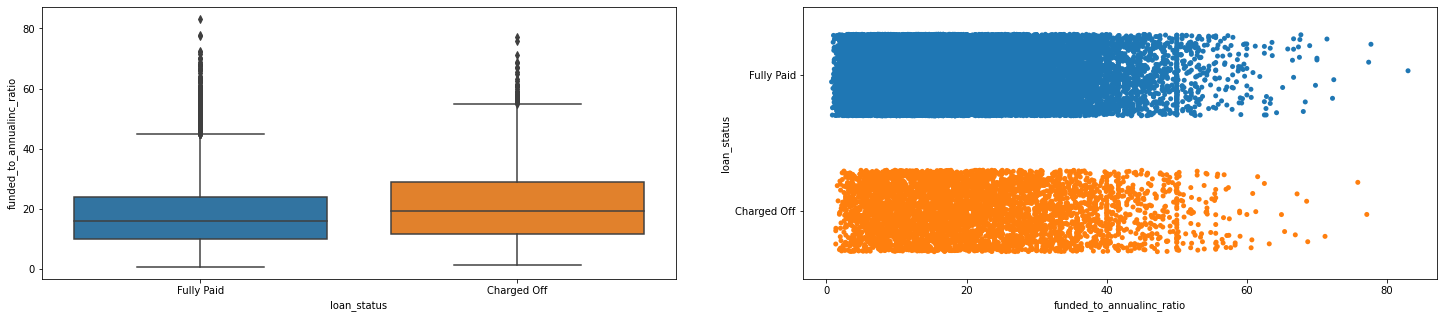

In [118]:
plotSimpleBivariateAnalysis('funded_to_annualinc_ratio',25,5)

**Observation**:
If funded amount was upto 40% of annual income, the default was less likely










### Term

Categorical and ordered. The number of payments on the loan. Values are in months and can be either 36 or 60.

In [119]:
z=df['term'].value_counts().reset_index(name='count').rename(columns={'index': 'term'})
z.head()

,term,count
0,36 months,26517
1,60 months,7970


<AxesSubplot:xlabel='term', ylabel='count'>

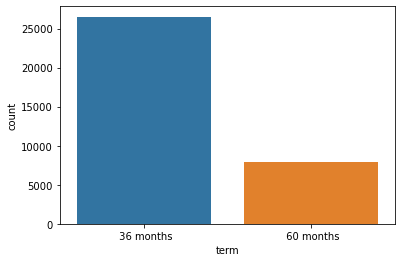

In [120]:
sns.barplot(y='count',x='term' ,data=z)

**Insights**
1. Majority of the loans were on shorter 36 months term

<AxesSubplot:xlabel='term', ylabel='count'>

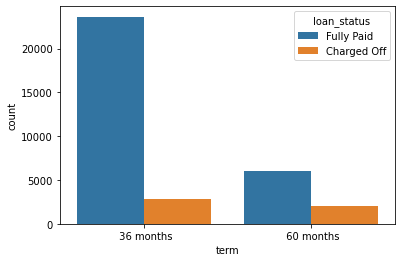

In [121]:
sns.countplot(x='term',data=df,hue='loan_status')

**Insights**
1. Loans default is high for 60 month term

In [122]:
def createRatioAndPlotBar(col):
  z=df[[f'{col}','loan_status']].value_counts().reset_index(name='counts')
  y=df[f'{col}'].value_counts().reset_index(name='totals').rename(columns={'index': f'{col}'})
  x=z.merge(y, how='left',on=f'{col}',)
  x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)
  return x


In [123]:
def plotForCategoricalForFullyPaidVsChargeOff(ds,col,width=10,height=5):
  plt.figure(figsize=(width,height))
  sns.barplot(x=f'{col}',y='ratio', data=ds,hue='loan_status')
  plt.xticks(rotation=90)


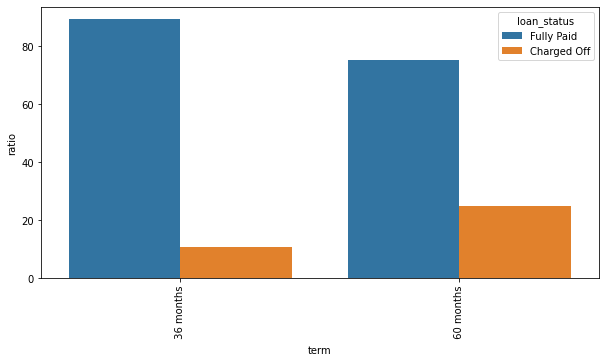

In [124]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('term'),'term')

**Observation**:
1.   Borrowers more likely to default if term is high 60 months 



### Verification status

Categorical. Indicates if income was verified by LC, not verified, or if the income source was verified

In [125]:
z=df['verification_status'].value_counts().reset_index(name='count').rename(columns={'index': 'verification_status'})
z.head()

,verification_status,count
0,Not Verified,15757
1,Verified,9939
2,Source Verified,8791


<AxesSubplot:xlabel='verification_status', ylabel='count'>

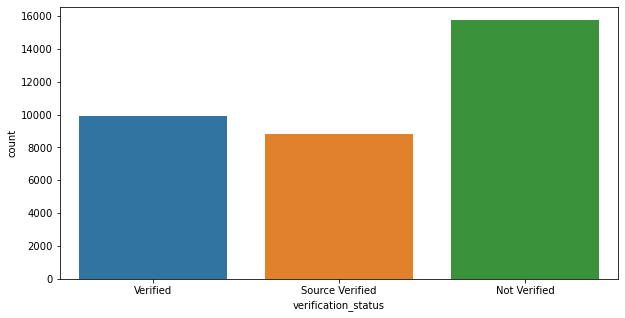

In [126]:
plt.figure(figsize=(10,5))
sns.countplot(x='verification_status',data=df)

**Insights**
1. Highest number of applicants were of Not verified category. 

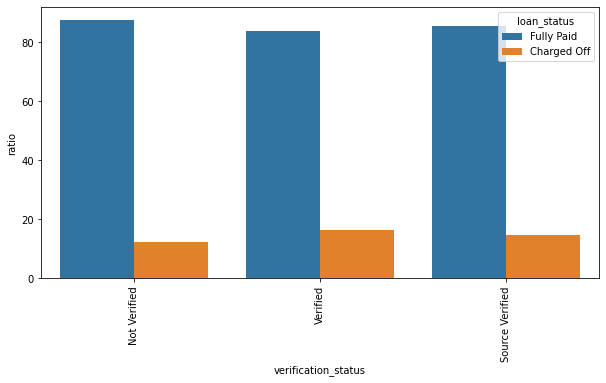

In [127]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('verification_status'),'verification_status')


**Observation**: 

1. Income verification status seems to have no positive correlation in reducing defaults.
2. LC verified applicants defaulted more followed by Source verified applicants 
3. Least default occured when applicant's income status was not verified

### int_rate

Numerical contineous. Interest Rate on the loan

In [128]:
df['int_rate'].nunique()

357

**Insights**
1. Around 357 unique interest rates were offered

In [129]:
df['int_rate'].describe()

count    34487.000000
mean        11.798877
std          3.570175
min          5.420000
25%          8.900000
50%         11.710000
75%         14.260000
max         22.110000
Name: int_rate, dtype: float64

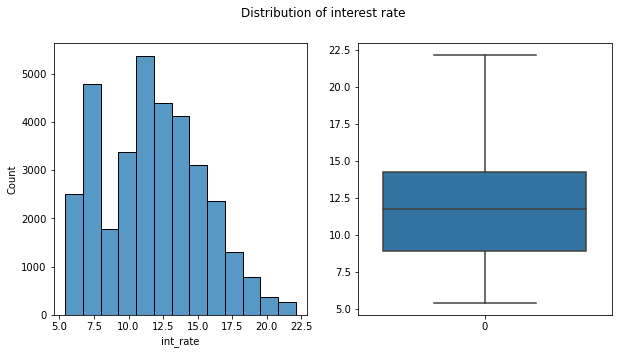

In [130]:
plotUnivariateAnalysis('int_rate','Distribution of interest rate',13)

In [131]:
iqr(df.int_rate)

5.359999999999999

**Insights**
1.   75% of borrowers borrowed at an interest rate of 14.2% or below
2.   50% of borrowers borrowed at an interest rate of 11.7% or below
3.   25% of borrowers borrowed at an interest rate of 8.9% or below
4.   Max interest rate at which a loan was borrowed was 22.1%
5.   Min interate rate at which a loan was borrowed was 5.4%
6.   IQR is at 5.35%
7.   Hist plot shows that majority of borrowers were offered an interest rate of 11%

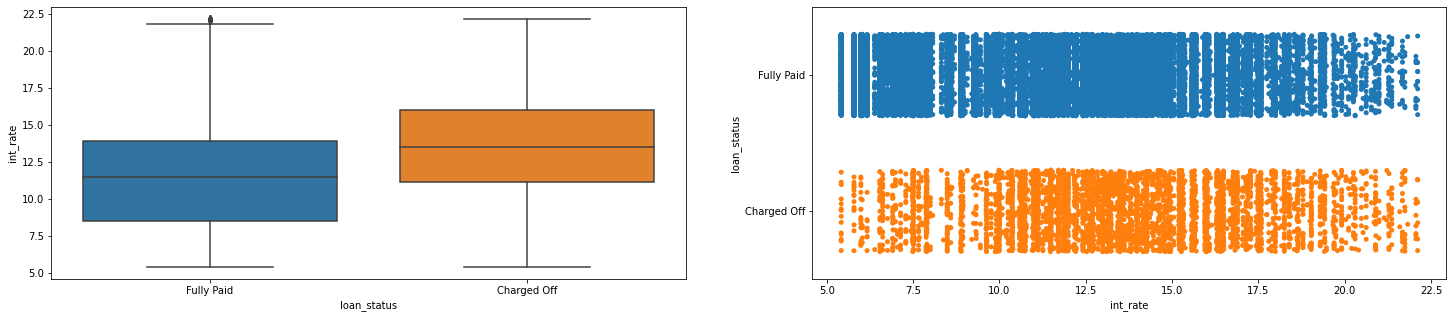

In [132]:
plotSimpleBivariateAnalysis('int_rate',25,5)

**Insights**
1. 75% of charge off's happened for interest rates of 16% and below
2. 50% of charge off's occured for interest rates of 14% and below
3. 25% of charge off's occured for interest rates of 11% and below
4. Strip plot shows trend that charged off customers were scattered higher above 12% interest rate. It is recommended that the interest rates be kept around 12 to 13% by LC

Binned ratio based analysis of fully paid vs charged off loans

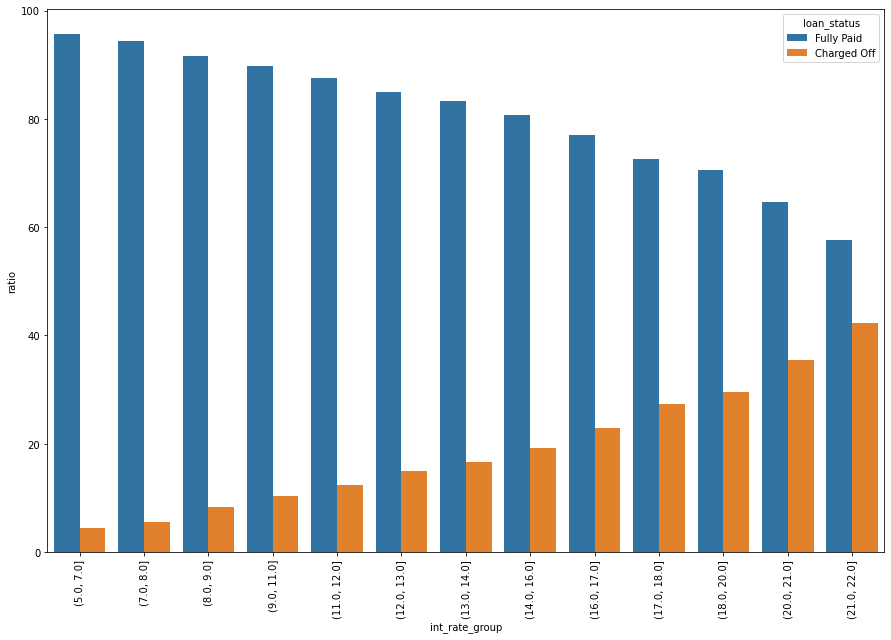

In [133]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('int_rate',13),'int_rate')

**Insights**
1.   Default increases with increase in interest rate



### grade

Categorical ordered. LC assigned loan grade

In [134]:
df.grade.nunique()

7

**Insights**
1. There are 7 grades defined from A to G

In [135]:
z=df['grade'].value_counts().reset_index(name='count').rename(columns={'index': 'grade'})

<AxesSubplot:xlabel='grade', ylabel='count'>

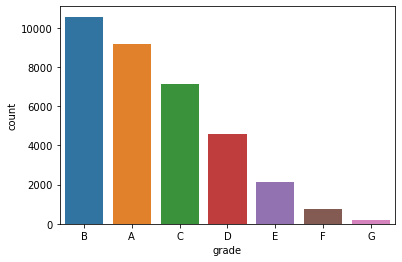

In [136]:
sns.barplot(y='count',x='grade' ,data=z)

**Insights**
1. Majority of the loans are of grade B followed by grade A

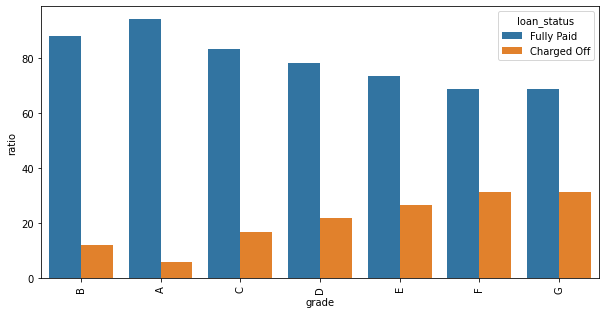

In [137]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('grade'),'grade')

**Observation**
1.   As the grade moves away from A, the tendency of default increases.
2.   Grade F and G have highest defaults



### sub_grade

Categorical ordered. LC assigned loan subgrade

In [138]:
df.sub_grade.nunique()

35

**Insights**
1. There are 35 unique sub grades defined by LC

In [139]:
z=df['sub_grade'].value_counts().reset_index(name='count').rename(columns={'index': 'sub_grade'})

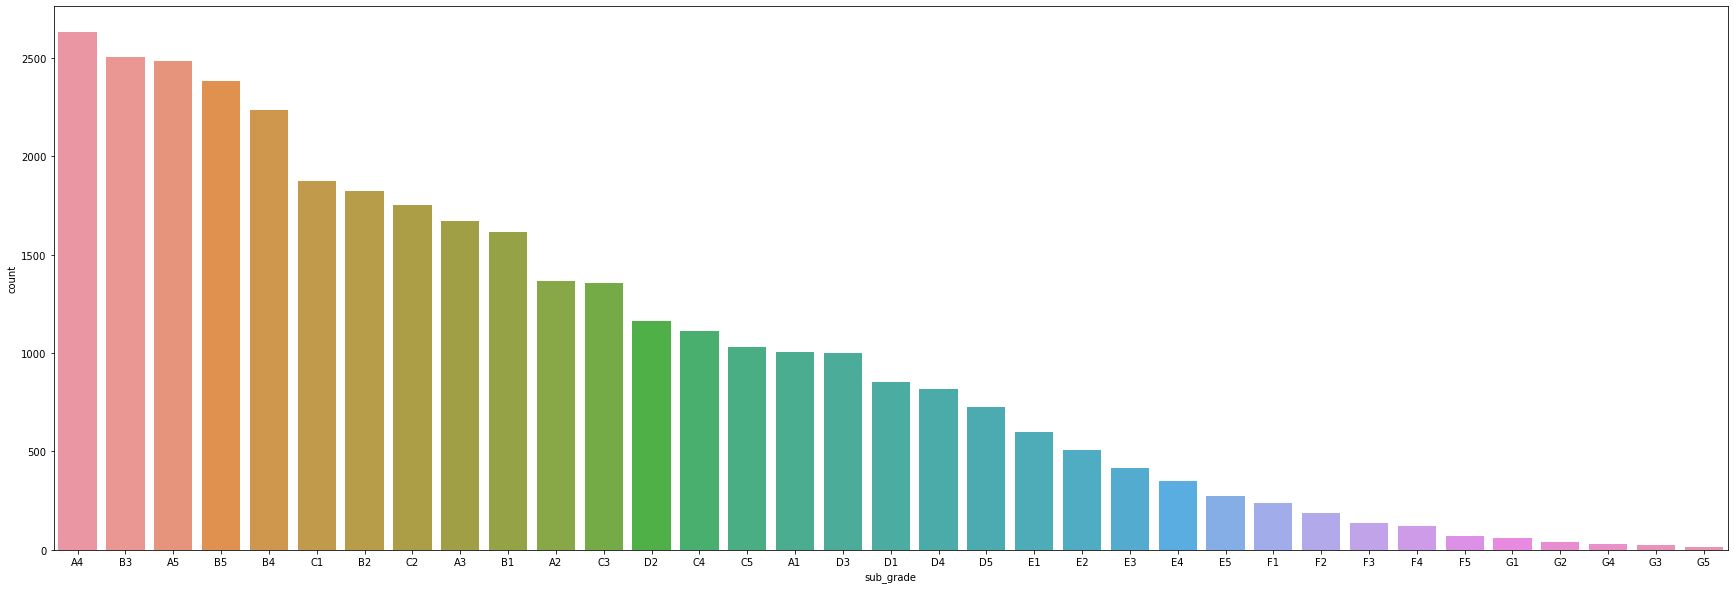

In [140]:
plt.figure(figsize=(30,10))
ax=sns.barplot(y='count',x='sub_grade' ,data=z)

**Insights**
1. Majority of the loans are of sub grade A4 followed by sub grade B3 and A5.
2. Significantly lower loans were offered in F and G grades

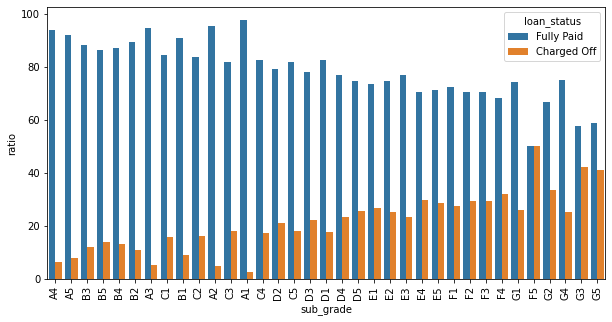

In [141]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('sub_grade'),'sub_grade')

**Observation**
1.   The likelyhood of default increases for these sub_grades F5,F2,E4,F3,F4,F1,E5,G3,G2,G1,F5,G5
2. Default was the highest for F5 category. ~50%


### emp_length

Numerical ordered. The length of employment of the borrower

In [142]:
df['emp_length'].nunique()

11

**Insights**
1. There are around 11 unique categories under which the employment length is segmented

In [143]:
df['emp_length'].describe()

count    34487.000000
mean         4.862122
std          3.537102
min          0.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         10.000000
Name: emp_length, dtype: float64

In [144]:
iqr(df.emp_length)

6.0

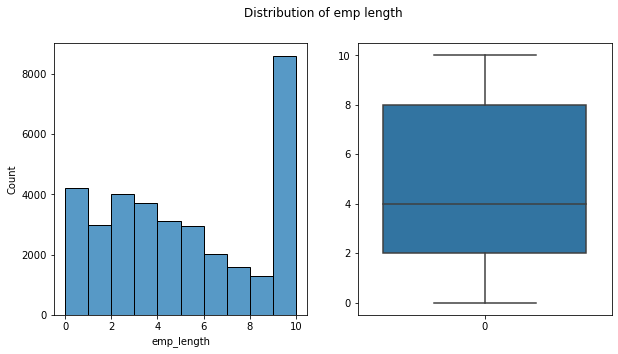

In [145]:
plotUnivariateAnalysis('emp_length','Distribution of emp length',10)

**Insights**
1. 75% of borrowers have 8 years employment length and below
2. 50% of borrowers have 4 years employment length and below
3. 25% of borrowers have 2 years employment length and below
4. Max employment length for borrowers was 10 years and above
5. Min employment length for borrowers were less than 1 year.
6. IQR is around 6 years of employment length
6. Hist plot shows that majority of borrowers had 10+ years of employment length.

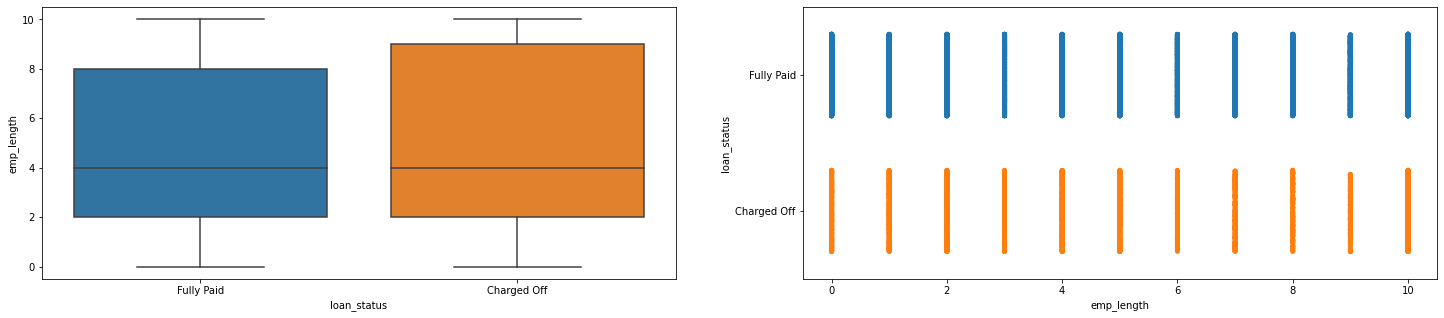

In [146]:
plotSimpleBivariateAnalysis('emp_length',25,5)

**Insights**
1. 75% of defaults occured were for employment length of 9 years and below
2. 50% of defaults occured were for employment length of 4 years and below
3. 25% of defaults occured were for employment length of 2 years and below
4. Loans with employment length between 4 to 9 years have higher default tendency.

Binned ratio based analysis of fully paid vs charged off loans

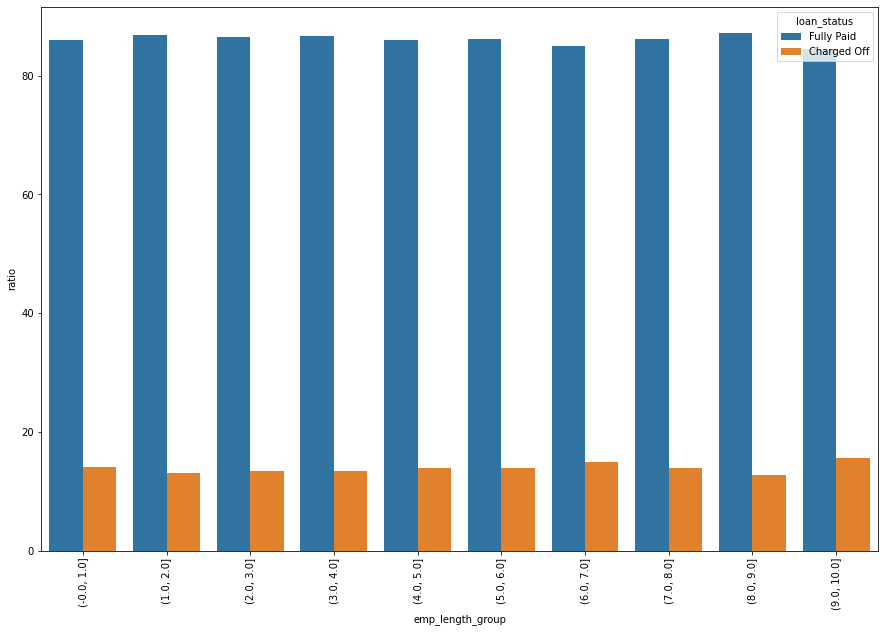

In [147]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('emp_length',10),'emp_length')

**Observation**

1.  No strong inference from ratio based plot 


### home_ownership

Categorical. The home ownership status provided by the borrower during registration. categories can be: RENT, OWN, MORTGAGE, OTHER.

In [148]:
df.home_ownership.nunique()

5

**Insigths**
1. There are 5 unique categories

In [149]:
z=df['home_ownership'].value_counts().reset_index(name='count').rename(columns={'index': 'home_ownership'})

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

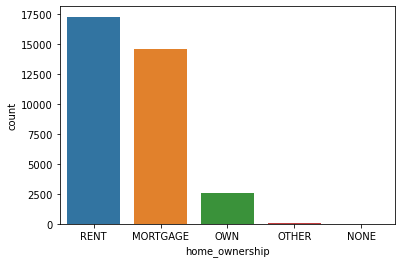

In [150]:
sns.barplot(y='count',x='home_ownership' ,data=z)

**Insights**
1. Majority of loans were borrowed by borrowers who rented a home.

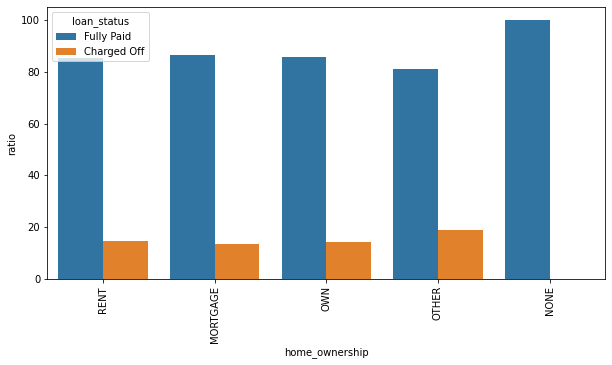

In [151]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('home_ownership'),'home_ownership')

**Observation**
1. Borrowers who reported home ownership as **other** defaulted more.


### Annual income

Numerical, ordered. The self-reported annual income provided by the borrower during registration.

In [152]:
df['annual_inc'].nunique()

4490

**Insights**
1. There are around 4562 unique salaries reported by borrowers.

In [153]:
df['annual_inc'].describe()

count     34487.000000
mean      60307.091260
std       26855.817127
min        4000.000000
25%       40000.000000
50%       55200.000000
75%       76000.000000
max      139992.000000
Name: annual_inc, dtype: float64

In [154]:
iqr(df.annual_inc)

36000.0

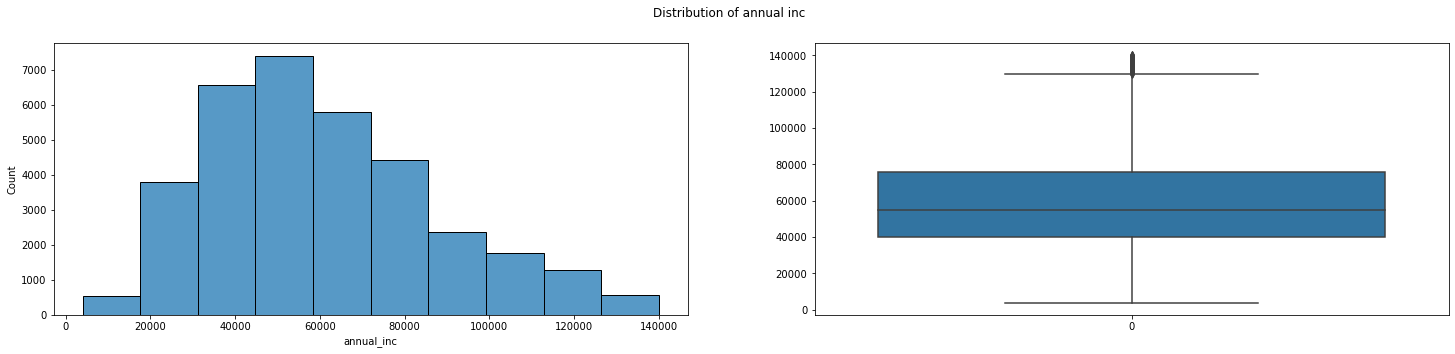

In [155]:
plotUnivariateAnalysis('annual_inc','Distribution of annual inc',10,25,5)

**Insights**
1. 75% of borrowers had annual income of 76000 and below
2. 50% of borrowers had annual income of 55530 and below
3. 25% of borrowers had annual income of 40000 and below
4. Max annual income reported by borrower is 139008
5. Min annual income reported by borrower is 4000
6. IRQ annual income is 36000
7. Hist plot shows trend that annual income reported by most of borrowers was between 50000 to 60000

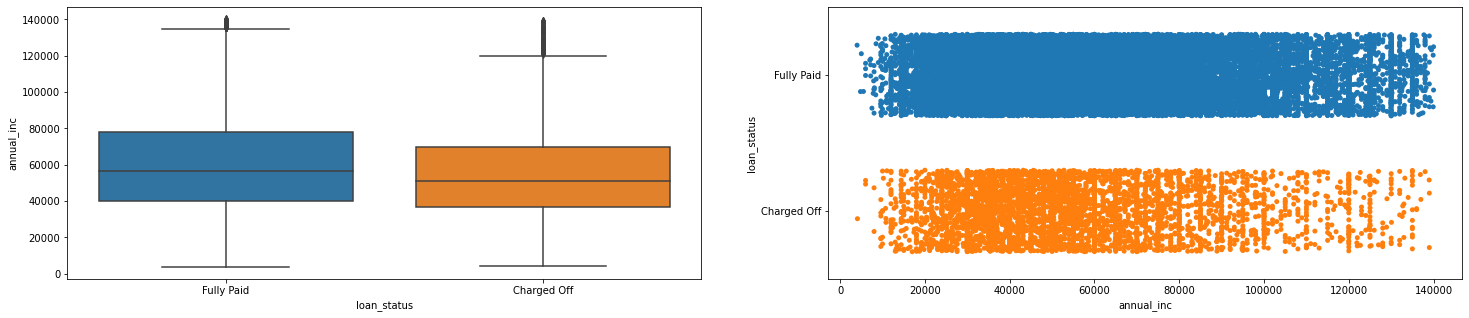

In [156]:
plotSimpleBivariateAnalysis('annual_inc',25,5)

**Insights**
1. 75% of defaults happened for borrowers with annual income of 76000
2. 50% of defaults happened for borrowers with annual income of 50000
3. 25% of defaults happened for borrowers with annual income of 40000
4. strip plot shows trend that defaults were more densely scattered for annual incomes between 20 to 76k

Binned ratio based analysis of fully paid vs charged off loans

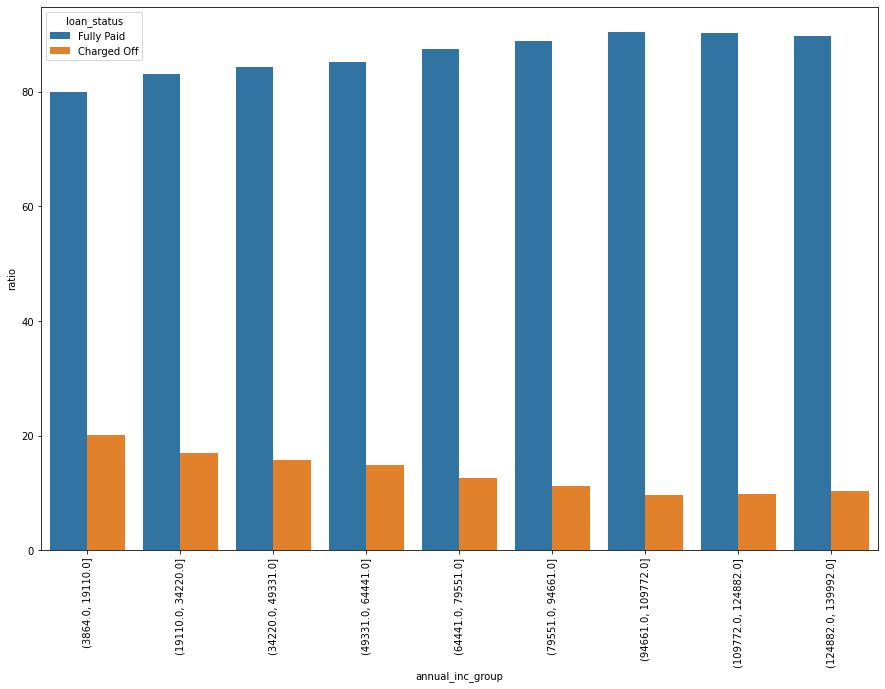

In [157]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('annual_inc',9),'annual_inc')

**Observation** 
1. Defaults decrease as the annual income increases.
Lending club should ensure the minimum annual pay is above 76000



###purpose

Categorical. A category provided by the borrower for the loan request. 

In [158]:
df.purpose.nunique()

14

**Insights**
1. There are around 14 unique purpose for borrowing loans

In [159]:
z=df['purpose'].value_counts().reset_index(name='count').rename(columns={'index': 'purpose'})

<AxesSubplot:xlabel='purpose', ylabel='count'>

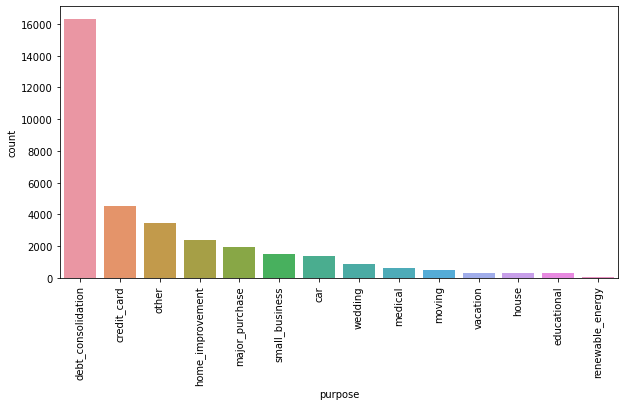

In [160]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.barplot(y='count',x='purpose' ,data=z)

**Insights**
1. Maximum loans were requested for the category of debt consolidation

[]

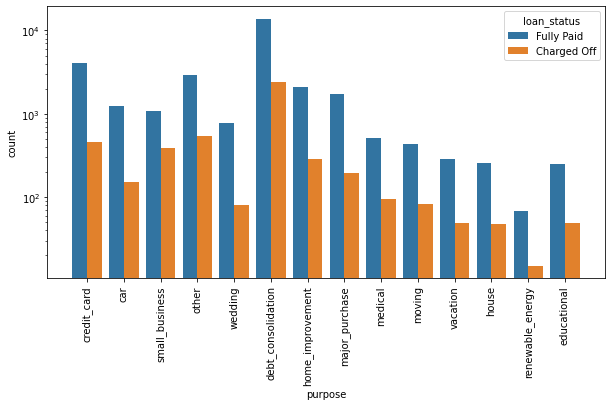

In [161]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
ax=sns.countplot(x='purpose',data=df,hue='loan_status')
ax.set_yscale('log')
ax.plot()

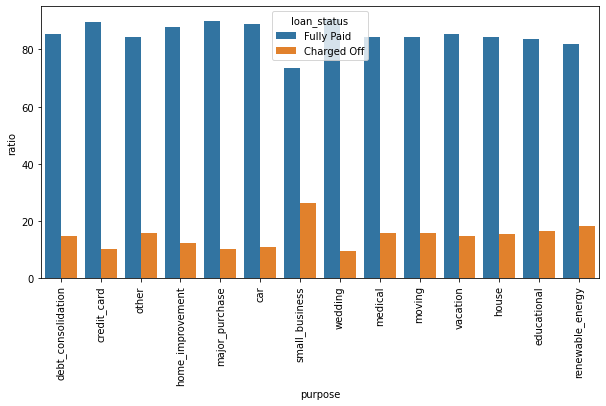

In [162]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('purpose'),'purpose')

**Observation**

1.   Count and ratio based bar plot both show a trend that loans taken by declaring the purpose of small businesses defaulted the most

### addr_state

Categorical. The state of residence provided by the borrower in the loan application

In [163]:
df.addr_state.nunique()

50

**Insights**
1. Loans were provided to borrowers of 50 states of United States

In [164]:
z=df['addr_state'].value_counts().reset_index(name='count').rename(columns={'index': 'addr_state'})

<AxesSubplot:xlabel='count', ylabel='addr_state'>

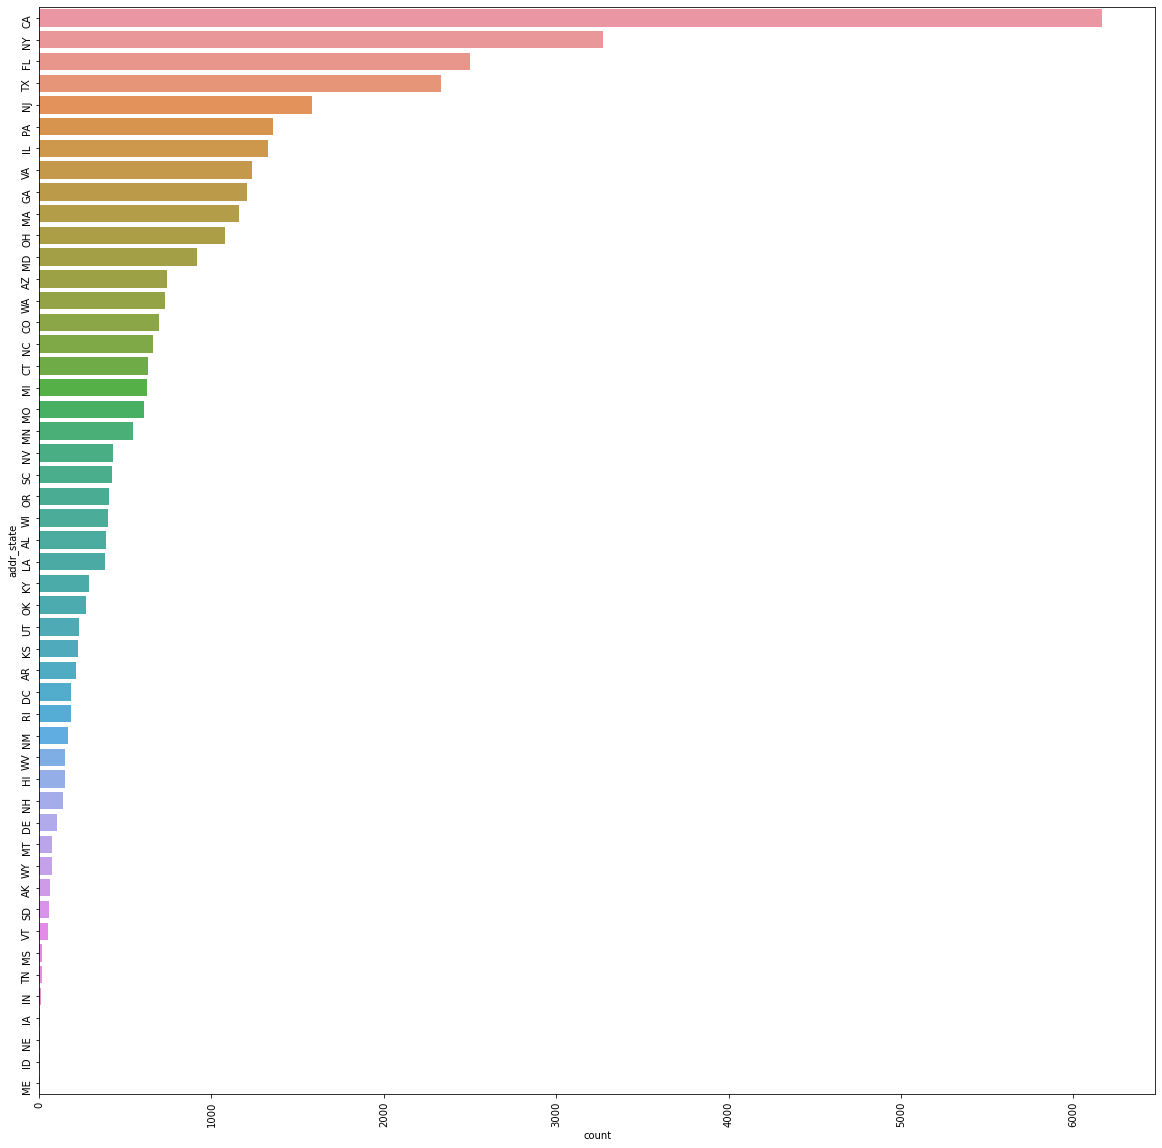

In [165]:
plt.figure(figsize=(20,20))
plt.xticks(rotation=90)
plt.yticks(rotation=90)
sns.barplot(x='count',y='addr_state' ,data=z)

**Insights**
1. Majority of loans were issued for borrowers from the state of CA (California)

[]

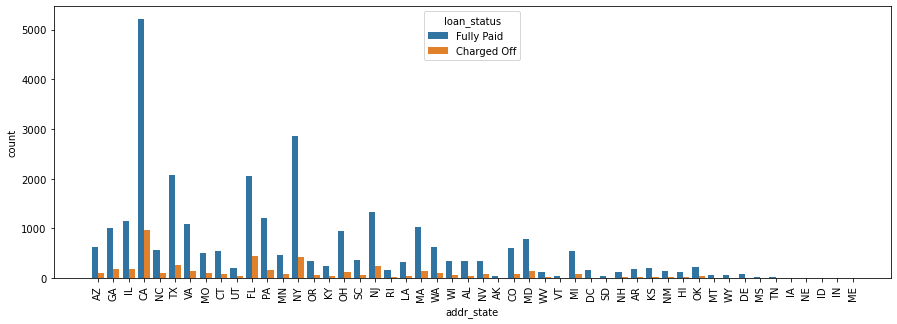

In [166]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
ax=sns.countplot(x='addr_state',data=df,hue='loan_status')
#ax.set_yscale('log')
ax.plot()

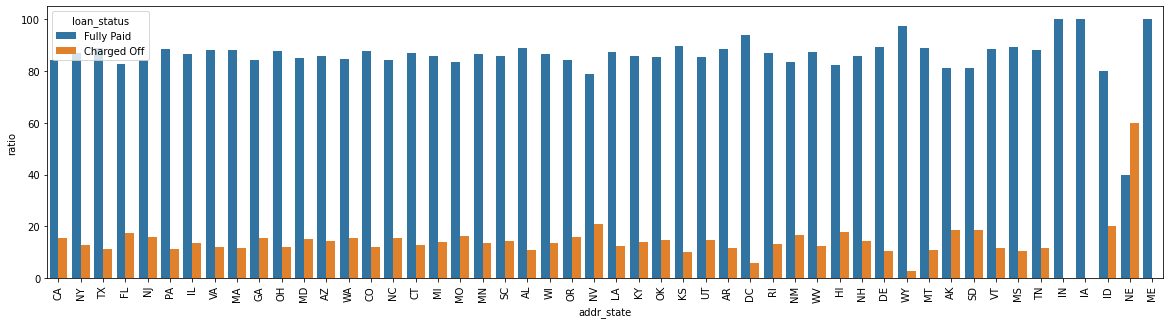

In [167]:
plotForCategoricalForFullyPaidVsChargeOff(createRatioAndPlotBar('addr_state'),'addr_state',20)

**Insights**
1. Defaults were high for borrowers from NE (Nebraska)
2. Defaults were lowerst for borrowers from IN(Indiana), LA(Louisiana) and ME(Maine)

Check if annual income had something to do with why NE have higher default

In [168]:
t=df[(df['addr_state'] == 'NE')]
t.groupby(by=['addr_state'])['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
addr_state,,,,,,,,
NE,5.0,49624.0,23269.870649,30000.0,32000.0,36120.0,75000.0,75000.0


No conclusion based on annual income.

Check if the interest rate was higher for these states

In [169]:
t['int_rate'].describe()

count     5.000000
mean     11.814000
std       1.383575
min       9.640000
25%      11.220000
50%      12.610000
75%      12.800000
max      12.800000
Name: int_rate, dtype: float64

No significant trend seen. However NV has max interest rate on higher side.

Check the funded amount

In [170]:
t['funded_amnt'].describe()

count        5.00000
mean      6340.00000
std       4954.08922
min       2500.00000
25%       2500.00000
50%       4800.00000
75%       7500.00000
max      14400.00000
Name: funded_amnt, dtype: float64

No significant trend seen

### dti

Numerical. A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [171]:
df.dti.nunique()

2838

**Insights**
1. There are around 2838 unique debt to income ratios defined

In [172]:
df['dti'].describe()

count    34487.000000
mean        13.448964
std          6.650262
min          0.000000
25%          8.360000
50%         13.570000
75%         18.700000
max         29.990000
Name: dti, dtype: float64

In [173]:
iqr(df.dti)

10.34

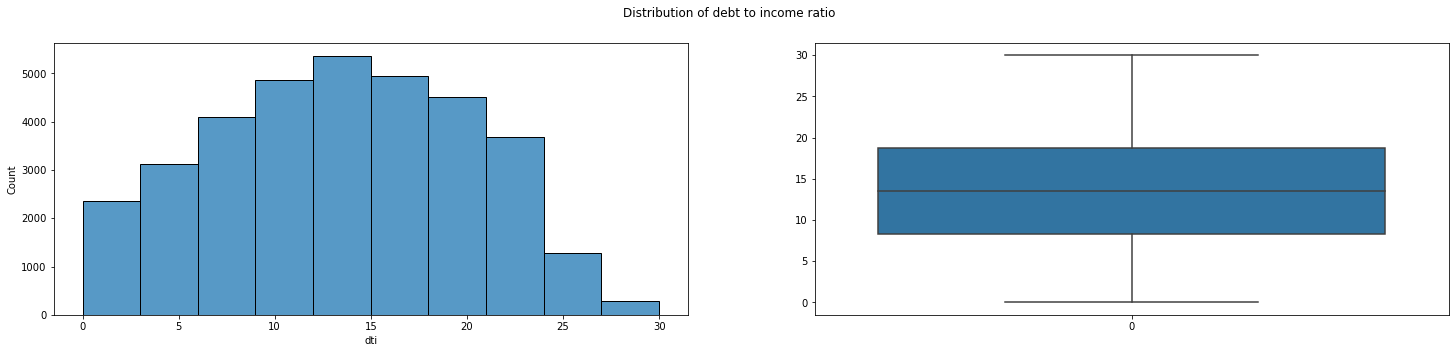

In [174]:
plotUnivariateAnalysis('dti','Distribution of debt to income ratio',10,25,5)

**Insights**
1.   75% of borrowers had a dti of 18.75 and below
2.   50% of borrowers had a dti of 13.6 and below
3.   25% of borrowers had a dti of 8.4 and below
4.   Hist plot shows the spread of dti between 12 to 15
5.   IQR of dti is 10.34

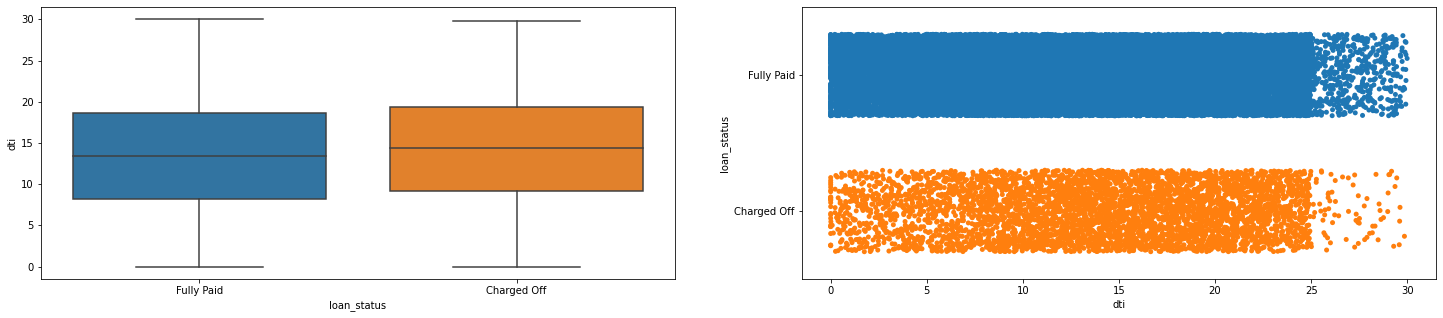

In [175]:
plotSimpleBivariateAnalysis('dti',25,5)

**Insights**
1. 75% of borrowers that charged off had a dti of 20 and below
2. 50% of borrowers that charged off had a dti of 15 and below
3. 25% of borrowers that charged off had a dti of 11 and below
4. Strip plot shows trend that Fully paid borrowers were scattered densely below dti of 25
5. Dti between 7 to 25 had higher defaults

Binned ratio based analysis of fully paid vs charged off loans

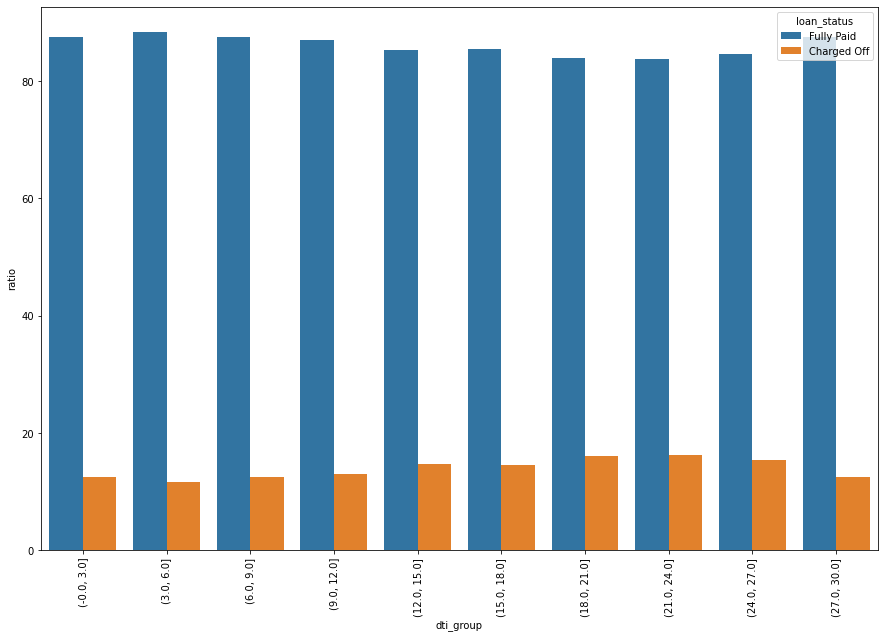

In [176]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('dti',10),'dti')

**Observation** 

1. Default increases if dti of borrowers is in the range 3 upto 24



###issue_d_month

The month which the loan was funded

In [177]:
df.issue_d_month.nunique()

12

The loans were issued in all the 12 months of the year

In [178]:
df['issue_d_month'].describe()

count    34487.000000
mean         7.083075
std          3.421513
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: issue_d_month, dtype: float64

In [179]:
iqr(df.issue_d_month)

6.0

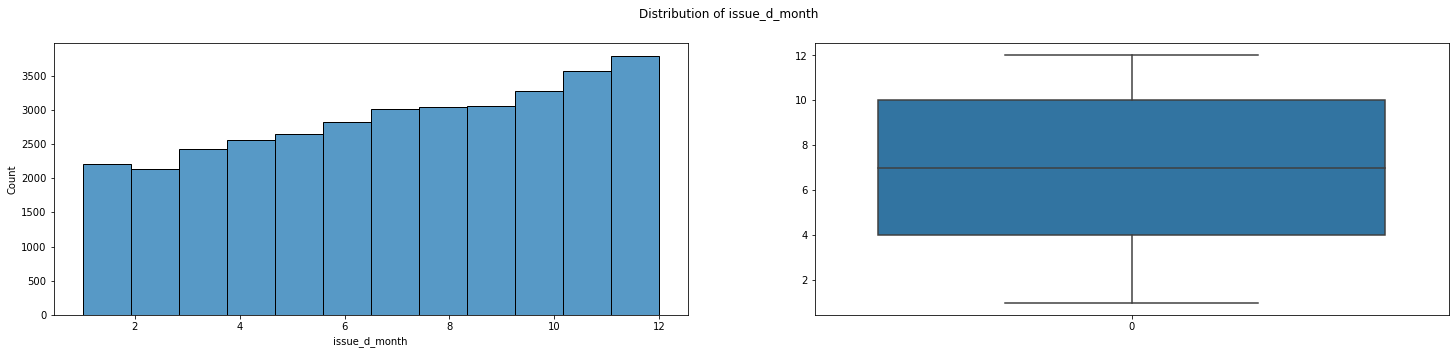

In [180]:
plotUnivariateAnalysis('issue_d_month','Distribution of issue_d_month',12,25,5)

**Insights**
1. 75% of the loans were issued by the month of October
2. 50% of the loans were issued by the month of July
3. 25% of the loans were issued by the month of April
4. Maximum number of loans were issued in the month of December
5. IRQ is 6 months

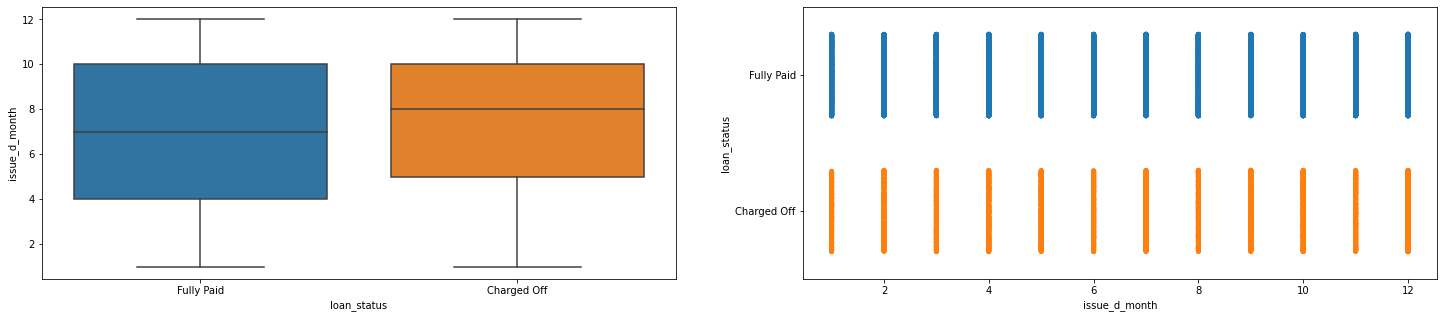

In [181]:
plotSimpleBivariateAnalysis('issue_d_month',25,5)

**Insights**
1. 75% of the charged off loans were issued by the month of October
2. 50% of the charged off loans were issued by the month of August
3. 25% of the charged off loans were issued by the month of May
4. Maximum loans were charged off between the month of May to August.

Binned ratio based analysis of fully paid vs charged off loans

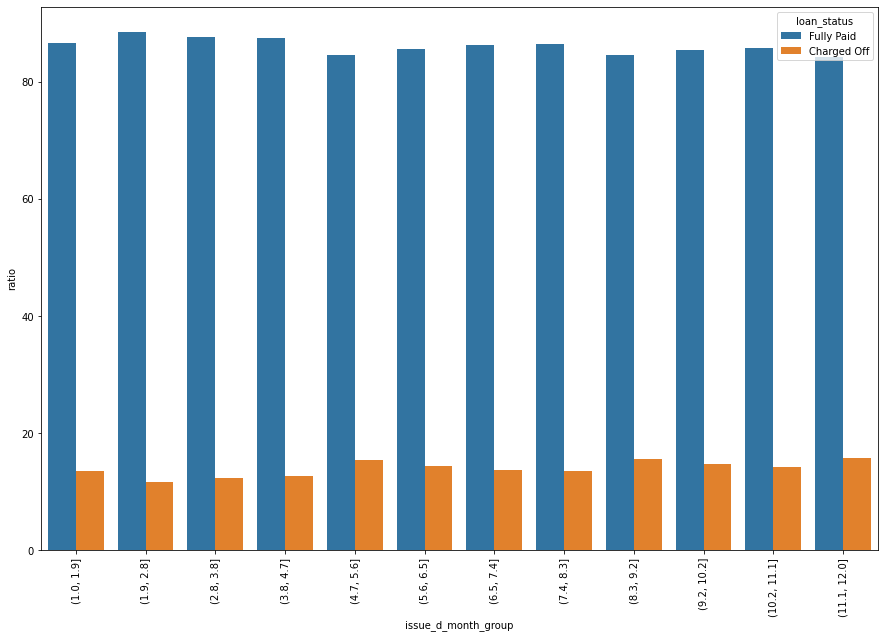

In [182]:
plotForFullyPaidVsChargeOff(createGroupAndPlotBar('issue_d_month',12),'issue_d_month')

Observation
1.   Charge off seems to be the lowest for the loans issued in the initial months from Jan to April with the lowest in the month of Feb


# Additional Insights: data Analysis for insights not directly related to problem statement

The analysis of the below fields we feel is outside the scope of the problem statement.

### member_id

Unique identifier for a member. continuous numerical variable. Hist plot for univariate analysis.

In [183]:
df['member_id'].nunique()

34487

35384 unique members are present in the loan data set

<AxesSubplot:xlabel='member_id', ylabel='Density'>

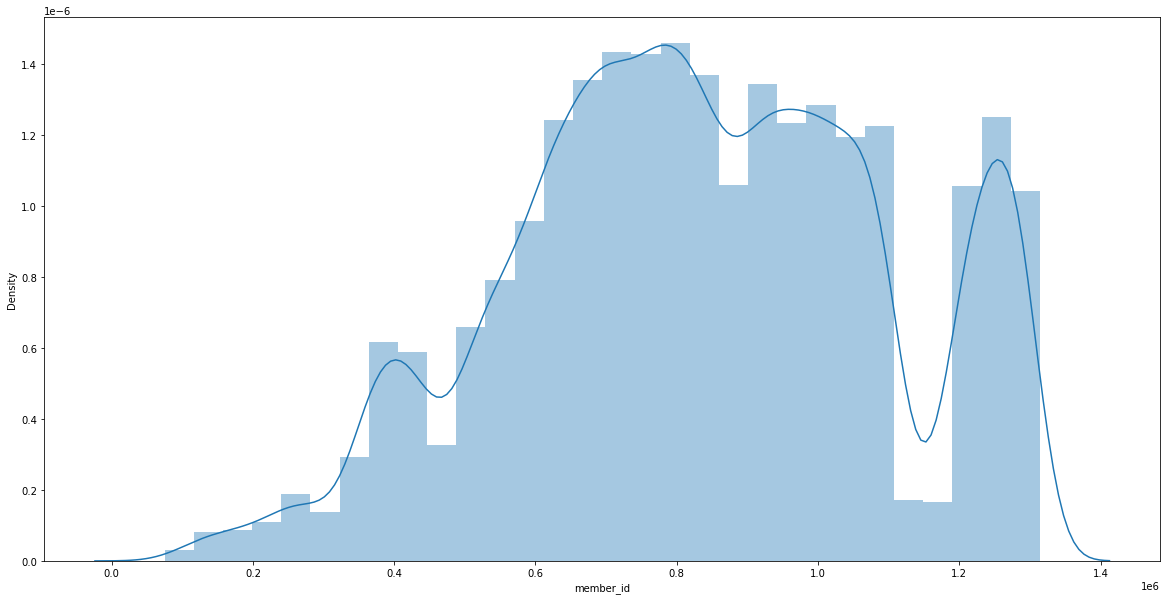

In [184]:
plt.figure(figsize=(20,10))
sns.distplot(a=df.member_id,bins=30,rug=False)

Observation : The members in the 8X series have taken more loans compared to others

### pub_rec

Number of derogatory public records

In [185]:
df.pub_rec.nunique()

5

In [186]:
df.pub_rec.value_counts()

0    32631
1     1804
2       44
3        6
4        2
Name: pub_rec, dtype: int64

In [187]:
df['pub_rec'].describe()

count    34487.000000
mean         0.055615
std          0.238359
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64

In [188]:
df.pub_rec.mode()

0    0
Name: pub_rec, dtype: int64

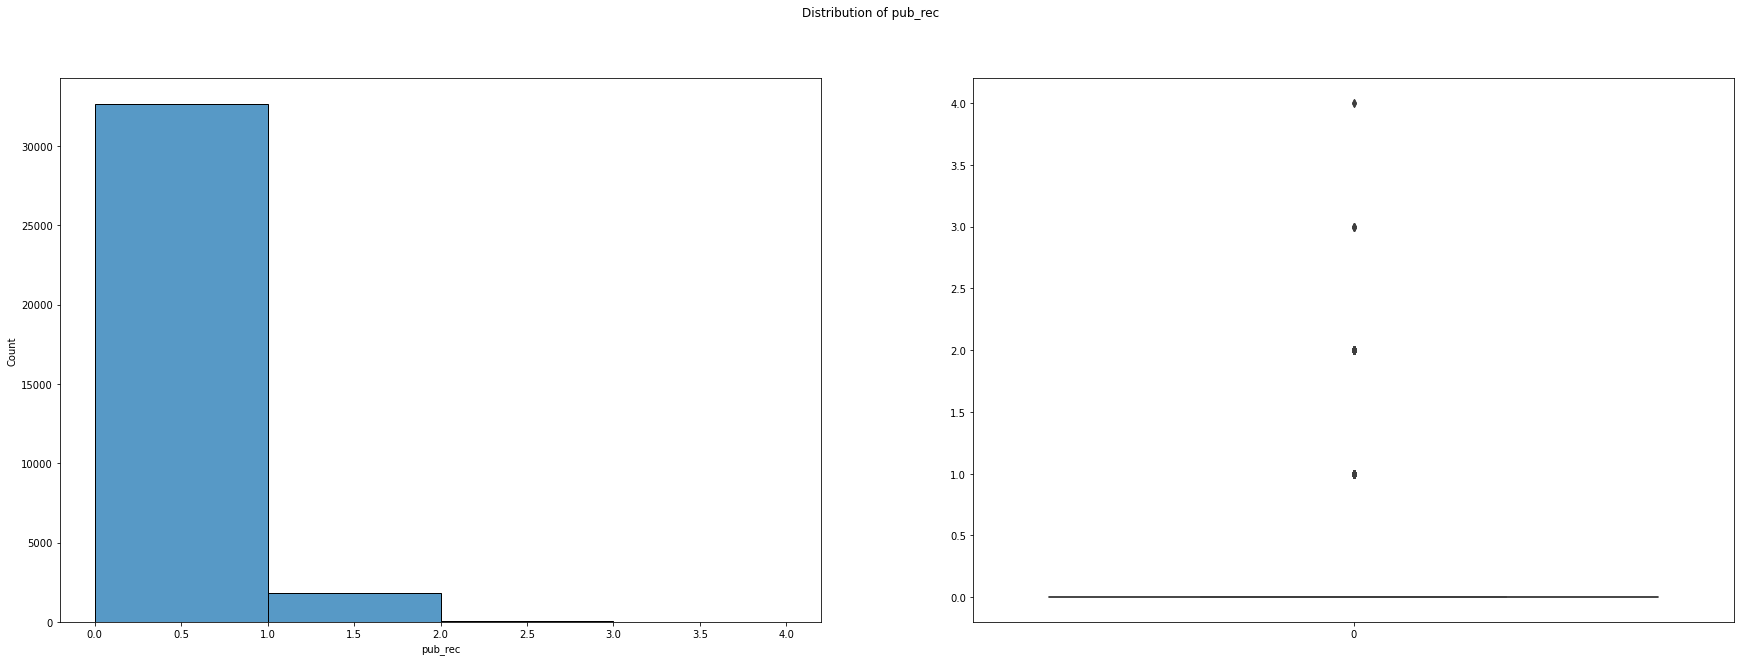

In [189]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.pub_rec,bins=4)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.pub_rec)
plt.suptitle('Distribution of pub_rec')
plt.show()

In [190]:
df[df.loan_status=='Fully Paid']['pub_rec'].describe()

count    29630.000000
mean         0.050827
std          0.229271
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64

In [191]:
df[df.loan_status=='Charged Off']['pub_rec'].describe()

count    4857.000000
mean        0.084826
std         0.285946
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: pub_rec, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='pub_rec'>

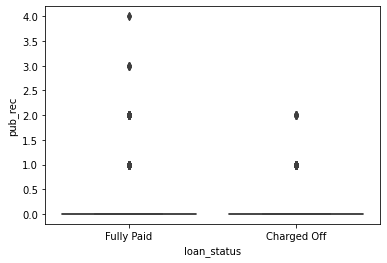

In [192]:
sns.boxplot(x='loan_status',y='pub_rec',data=df)

In [193]:
z=df[['pub_rec','loan_status']].value_counts().reset_index(name='count')
z.head(100)

,pub_rec,loan_status,count
0,0,Fully Paid,28176
1,0,Charged Off,4455
2,1,Fully Paid,1412
3,1,Charged Off,392
4,2,Fully Paid,34
5,2,Charged Off,10
6,3,Fully Paid,6
7,4,Fully Paid,2


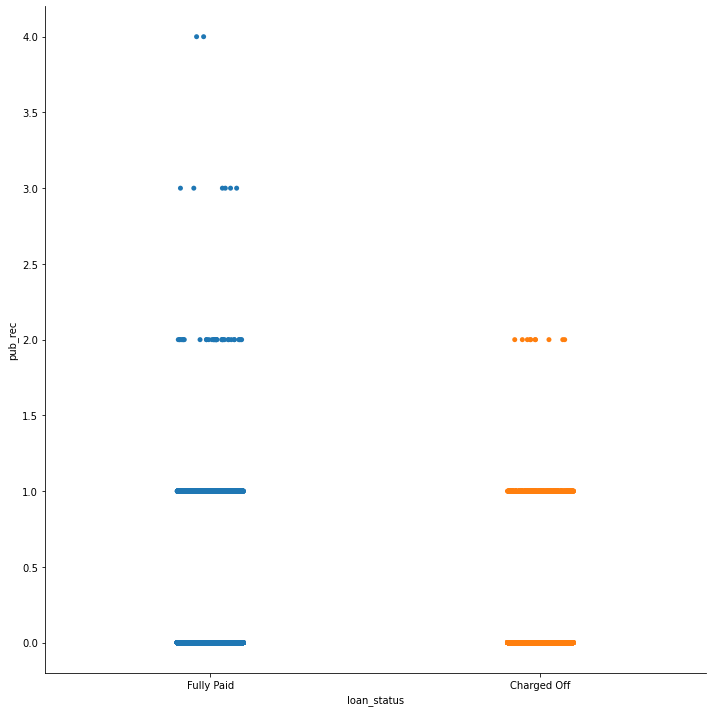

In [194]:
sns.catplot(data=df[['pub_rec','loan_status']],y='pub_rec',x='loan_status',size=10, aspect=1)
plt.show()

In [195]:
z=df[['pub_rec','loan_status']].value_counts().reset_index(name='counts')
y=df.pub_rec.value_counts().reset_index(name='totals').rename(columns={'index': 'pub_rec'})
x=z.merge(y, how='left',on='pub_rec',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100,axis=1)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

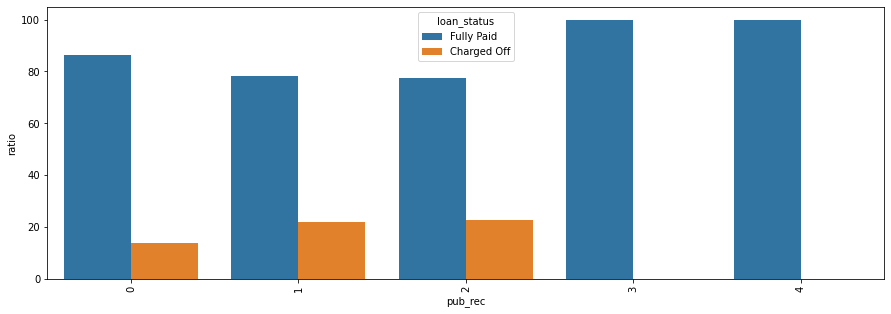

In [196]:
plt.figure(figsize=(15,5))
sns.barplot(x='pub_rec',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation 
1.   Majority of borrowers had 0 derogatory public record
2.   As the derogatory public records increased, the likelyhood of default increased upto 1. Slightly decreased for 2 public records.
3.  There were no charge off for 3 derogatory public record or more.




### pub_rec_bankruptcies

In [197]:
df.pub_rec_bankruptcies.nunique()

3

In [198]:
df.pub_rec_bankruptcies.value_counts()

0.0    33023
1.0     1459
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

In [199]:
df['pub_rec_bankruptcies'].describe()

count    34487.000000
mean         0.042596
std          0.202664
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

In [200]:
df.pub_rec_bankruptcies.mode()

0    0.0
Name: pub_rec_bankruptcies, dtype: float64

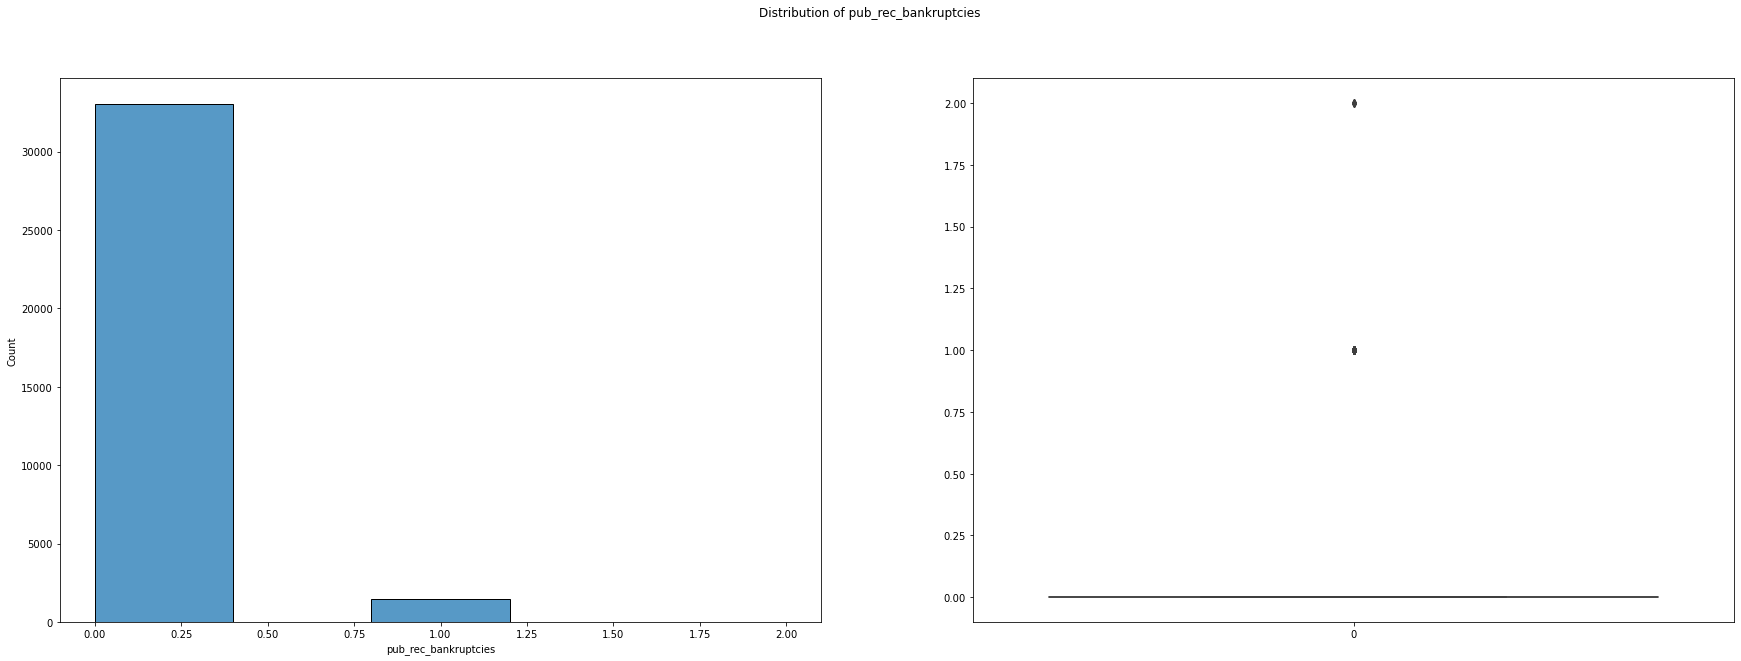

In [201]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.pub_rec_bankruptcies,bins=5)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.pub_rec_bankruptcies)
plt.suptitle('Distribution of pub_rec_bankruptcies')
plt.show()

In [202]:
df[df.loan_status=='Fully Paid']['pub_rec_bankruptcies'].describe()

count    29630.000000
mean         0.038981
std          0.194075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

In [203]:
df[df.loan_status=='Charged Off']['pub_rec_bankruptcies'].describe()

count    4857.000000
mean        0.064649
std         0.247600
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: pub_rec_bankruptcies, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='pub_rec_bankruptcies'>

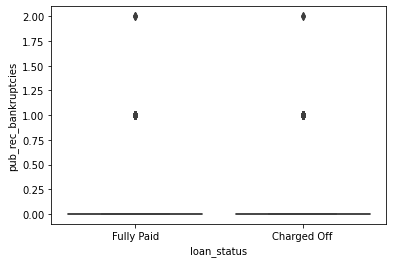

In [204]:
sns.boxplot(x='loan_status',y='pub_rec_bankruptcies',data=df)

In [205]:
z=df[['pub_rec_bankruptcies','loan_status']].value_counts().reset_index(name='count')
z.head(100)

,pub_rec_bankruptcies,loan_status,count
0,0.0,Fully Paid,28478
1,0.0,Charged Off,4545
2,1.0,Fully Paid,1149
3,1.0,Charged Off,310
4,2.0,Fully Paid,3
5,2.0,Charged Off,2


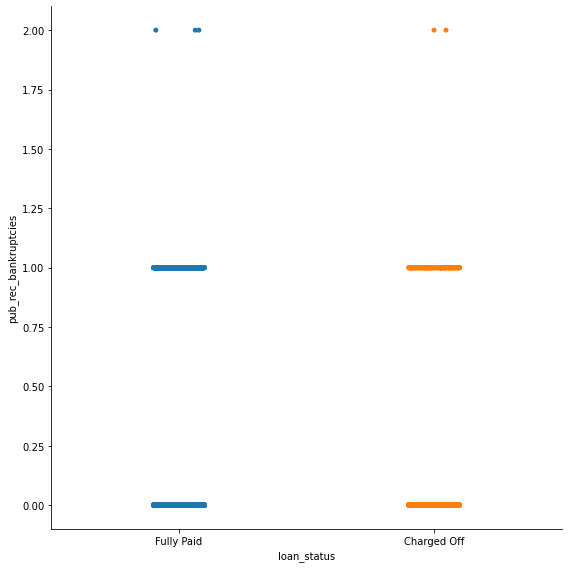

In [206]:
sns.catplot(data=df[['pub_rec_bankruptcies','loan_status']],y='pub_rec_bankruptcies',x='loan_status',size=8, aspect=1)
plt.show()

In [207]:
z=df[['pub_rec_bankruptcies','loan_status']].value_counts().reset_index(name='counts')
y=df.pub_rec_bankruptcies.value_counts().reset_index(name='totals').rename(columns={'index': 'pub_rec_bankruptcies'})
x=z.merge(y, how='left',on='pub_rec_bankruptcies',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([0, 1, 2]), [Text(0, 0, '0.0'), Text(1, 0, '1.0'), Text(2, 0, '2.0')])

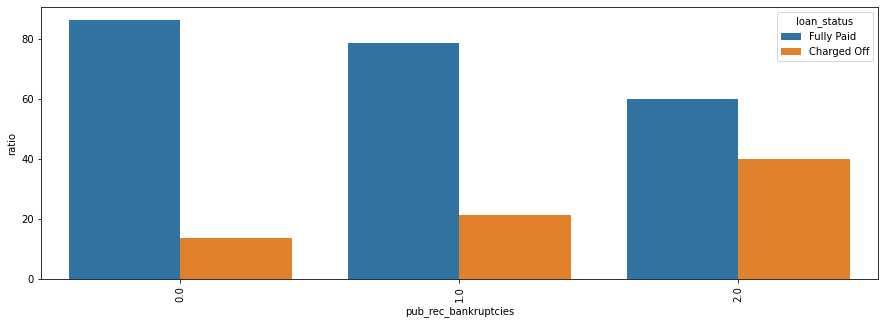

In [208]:
plt.figure(figsize=(15,5))
sns.barplot(x='pub_rec_bankruptcies',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation 
1.   Majority of borrowers had 0 public record of bankrupcy
2.   13.5% of borrowers with 0 bankrupcy records defaulted
3.   21% of borrowers with 1 bankrupcy record defaulted
4.   28.5% of borrowers with 2 bankrupcy record defaulted.
2.   Borrowers with more bankrupcy records defaulted




###total_acc

In [209]:
df.total_acc.nunique()

81

In [210]:
df.total_acc.value_counts()

15    1321
16    1320
14    1309
17    1289
20    1279
      ... 
79       1
87       1
74       1
78       1
76       1
Name: total_acc, Length: 81, dtype: int64

In [211]:
df['total_acc'].describe()

count    34487.000000
mean        21.501145
std         11.168086
min          2.000000
25%         13.000000
50%         20.000000
75%         28.000000
max         90.000000
Name: total_acc, dtype: float64

In [212]:
df.total_acc.mode()

0    15
Name: total_acc, dtype: int64

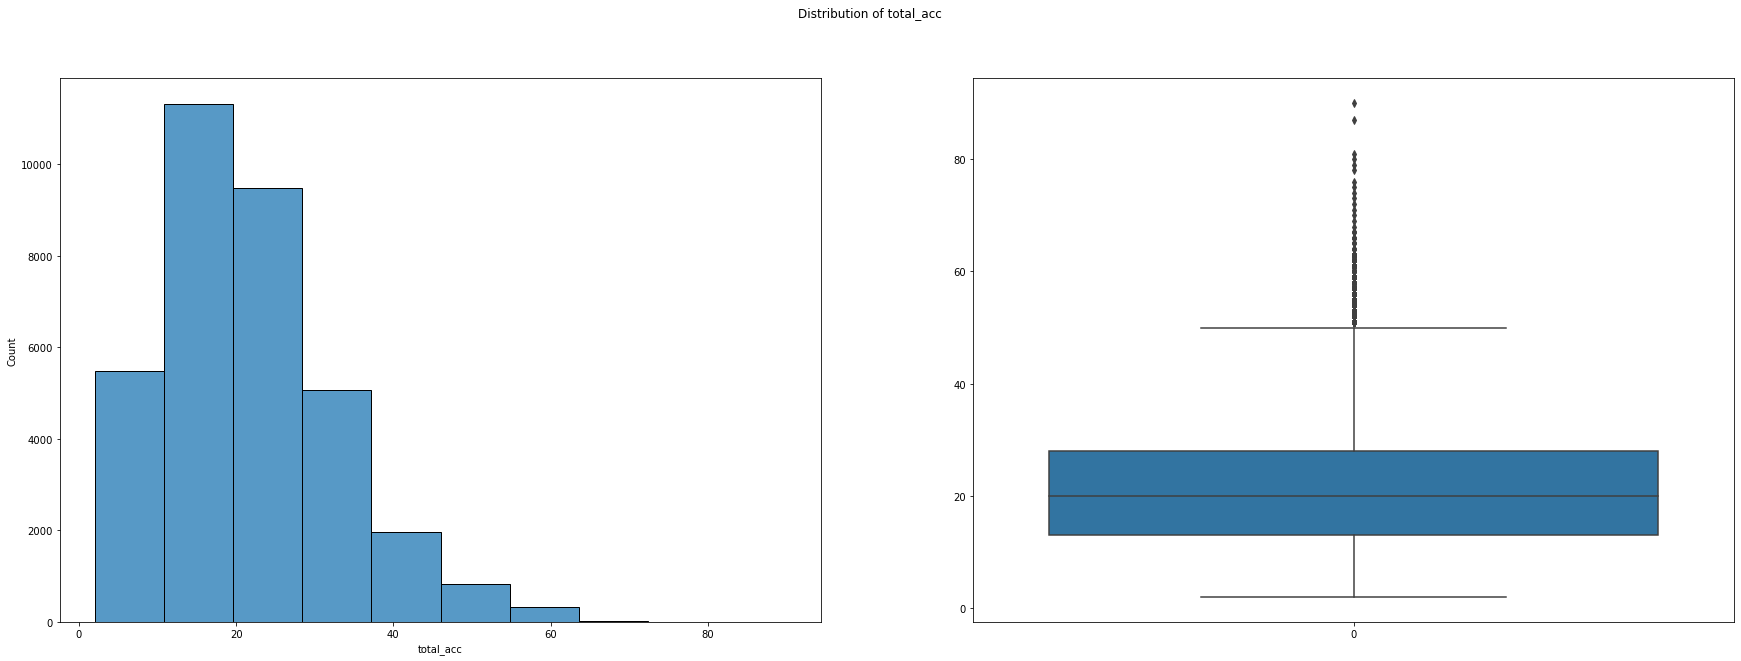

In [213]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.total_acc,bins=10)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.total_acc)
plt.suptitle('Distribution of total_acc')
plt.show()

In [214]:
df[df.loan_status=='Fully Paid']['total_acc'].describe()

count    29630.000000
mean        21.586871
std         11.152928
min          2.000000
25%         13.000000
50%         20.000000
75%         28.000000
max         90.000000
Name: total_acc, dtype: float64

In [215]:
df[df.loan_status=='Charged Off']['total_acc'].describe()

count    4857.000000
mean       20.978176
std        11.247127
min         2.000000
25%        12.000000
50%        19.000000
75%        28.000000
max        74.000000
Name: total_acc, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='total_acc'>

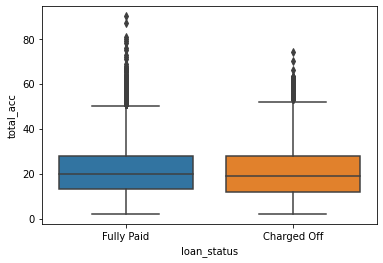

In [216]:
sns.boxplot(x='loan_status',y='total_acc',data=df)

In [217]:
z=df[['total_acc','loan_status']].value_counts().reset_index(name='count')
z.head(100)

,total_acc,loan_status,count
0,15,Fully Paid,1139
1,16,Fully Paid,1115
2,20,Fully Paid,1114
3,17,Fully Paid,1109
4,14,Fully Paid,1105
...,...,...,...
95,57,Fully Paid,30
96,45,Charged Off,29
97,59,Fully Paid,28
98,42,Charged Off,28


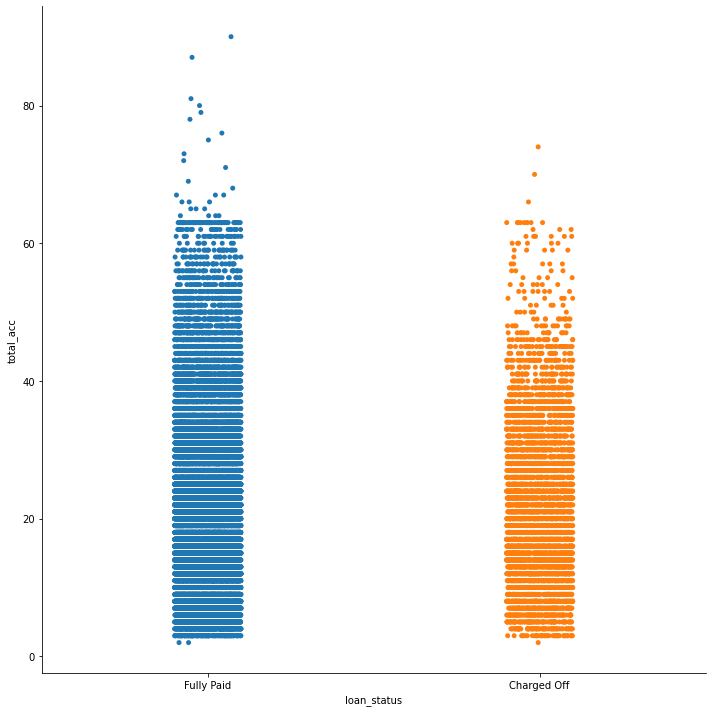

In [218]:
sns.catplot(data=df[['total_acc','loan_status']],x='loan_status',y='total_acc',size=10, aspect=1)
plt.show()

Segment the numerical variable into categorical as the counts are a bit high

In [219]:
df['acc_group'] = pd.cut(df['total_acc'], bins=11,precision =0,labels=['2-5','5-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])

In [220]:
z=df[['acc_group','loan_status']].value_counts().reset_index(name='counts')
y=df.acc_group.value_counts().reset_index(name='totals').rename(columns={'index': 'acc_group'})
x=z.merge(y, how='left',on='acc_group',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2-5'),
  Text(1, 0, '5-10'),
  Text(2, 0, '10-20'),
  Text(3, 0, '20-30'),
  Text(4, 0, '30-40'),
  Text(5, 0, '40-50'),
  Text(6, 0, '50-60'),
  Text(7, 0, '60-70'),
  Text(8, 0, '70-80'),
  Text(9, 0, '80-90'),
  Text(10, 0, '90-100')])

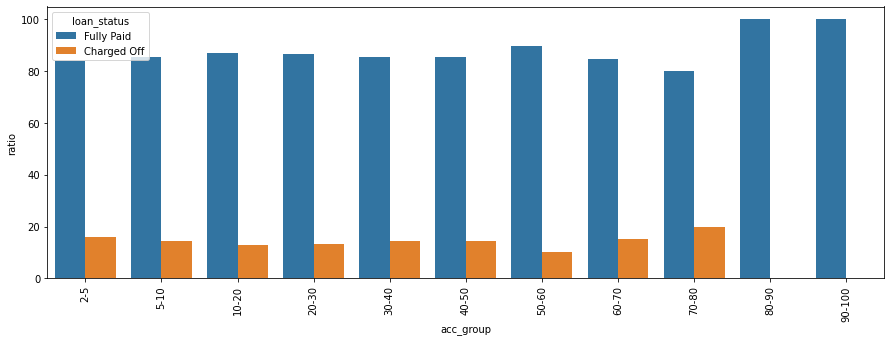

In [221]:
plt.figure(figsize=(15,5))
sns.barplot(x='acc_group',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation

1.   75% of the borrowers have 29 credit line accounts or below
2.   50% of the borrowers have 20 credit line accounts or below
3.   25% of the borrowers have 14 credit line accounts or below
4.   Hist plot shows the frequency of 10 to 18 accounts is highest in the dataset
5.   There is a slight increase in default if the number of accounts is between 70-80
6.   The default seems to be less likely if the number of accounts is between 50-65


###revol_bal

Total credit revolving balance

In [222]:
df.revol_bal.nunique()

19369

In [223]:
df.revol_bal.value_counts()

0        821
1         11
255       10
39         9
1763       8
        ... 
11768      1
2026       1
14817      1
23754      1
66033      1
Name: revol_bal, Length: 19369, dtype: int64

In [224]:
df['revol_bal'].describe()

count     34487.000000
mean      12062.114333
std       13375.624727
min           0.000000
25%        3551.000000
50%        8413.000000
75%       15850.500000
max      149000.000000
Name: revol_bal, dtype: float64

In [225]:
df.revol_bal.mode()

0    0
Name: revol_bal, dtype: int64

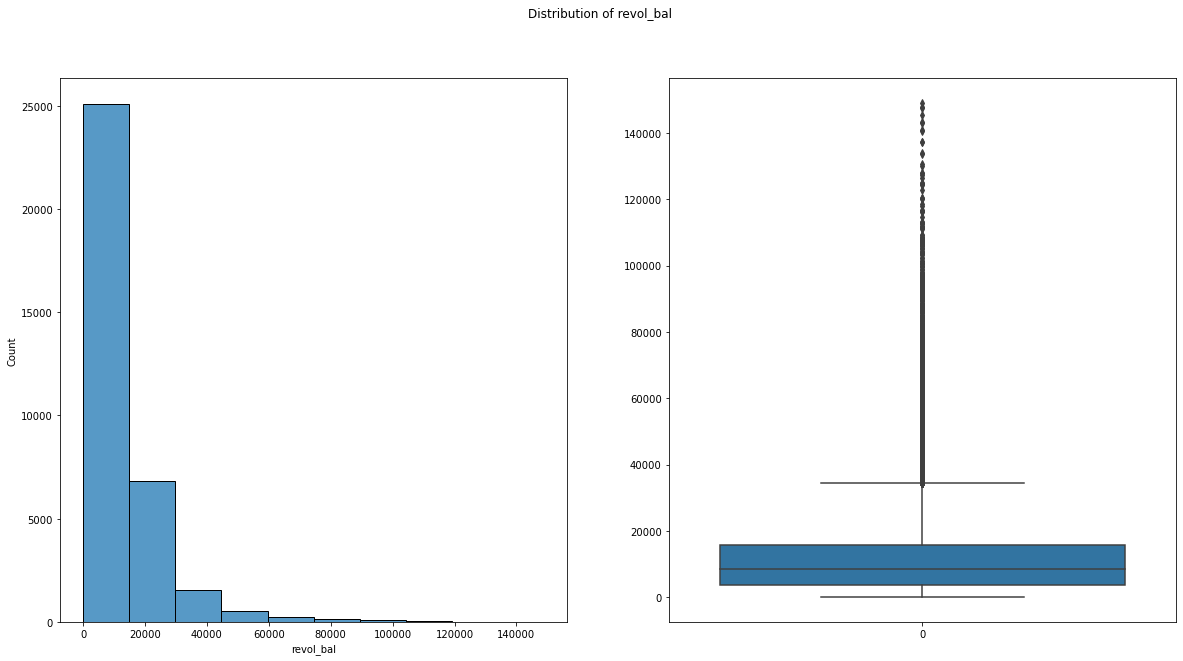

In [226]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.revol_bal,bins=10)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.revol_bal)
plt.suptitle('Distribution of revol_bal')
plt.show()

In [227]:
df[df.loan_status=='Fully Paid']['revol_bal'].describe()

count     29630.000000
mean      11990.869288
std       13366.915423
min           0.000000
25%        3492.250000
50%        8335.000000
75%       15714.500000
max      149000.000000
Name: revol_bal, dtype: float64

In [228]:
df[df.loan_status=='Charged Off']['revol_bal'].describe()

count      4857.000000
mean      12496.742845
std       13421.824250
min           0.000000
25%        3902.000000
50%        8818.000000
75%       16477.000000
max      137112.000000
Name: revol_bal, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='revol_bal'>

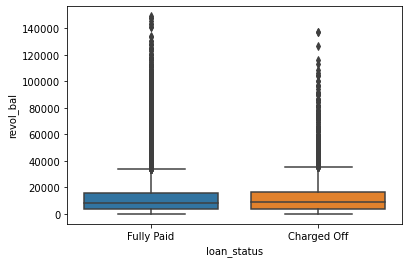

In [229]:
sns.boxplot(x='loan_status',y='revol_bal',data=df)

In [230]:
z=df[['revol_bal','loan_status']].value_counts().reset_index(name='count')
z.head(100)

,revol_bal,loan_status,count
0,0,Fully Paid,699
1,0,Charged Off,122
2,1,Fully Paid,10
3,255,Fully Paid,10
4,39,Fully Paid,9
...,...,...,...
95,2269,Fully Paid,6
96,2745,Fully Paid,6
97,2914,Fully Paid,6
98,2983,Fully Paid,6


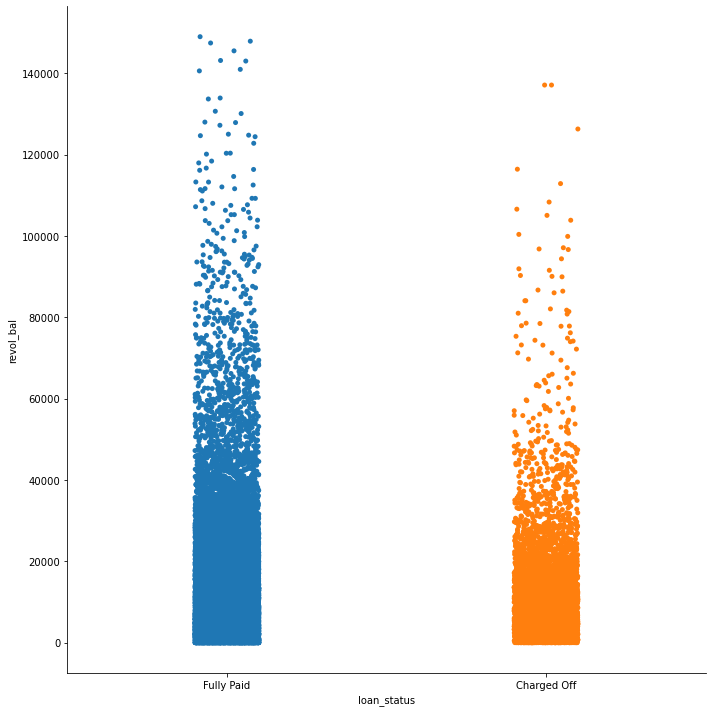

In [231]:
sns.catplot(data=df[['revol_bal','loan_status']],x='loan_status',y='revol_bal',size=10, aspect=1)
plt.show()

Segment the numerical variable into categorical as the counts are a bit high

In [232]:
df['revol_bal_group'] = pd.cut(df['revol_bal'], bins=10,precision =0)

In [233]:
z=df[['revol_bal_group','loan_status']].value_counts().reset_index(name='counts')
y=df.revol_bal_group.value_counts().reset_index(name='totals').rename(columns={'index': 'revol_bal_group'})
x=z.merge(y, how='left',on='revol_bal_group',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(-149.0, 14900.0]'),
  Text(1, 0, '(14900.0, 29800.0]'),
  Text(2, 0, '(29800.0, 44700.0]'),
  Text(3, 0, '(44700.0, 59600.0]'),
  Text(4, 0, '(59600.0, 74500.0]'),
  Text(5, 0, '(74500.0, 89400.0]'),
  Text(6, 0, '(89400.0, 104300.0]'),
  Text(7, 0, '(104300.0, 119200.0]'),
  Text(8, 0, '(119200.0, 134100.0]'),
  Text(9, 0, '(134100.0, 149000.0]')])

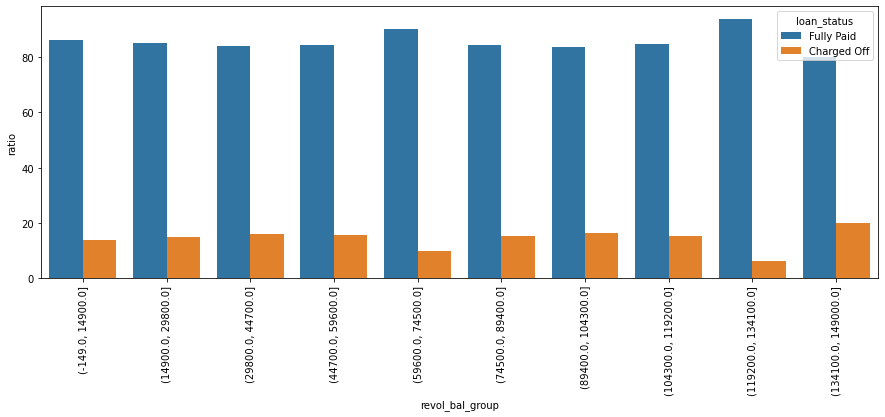

In [234]:
plt.figure(figsize=(15,5))
sns.barplot(x='revol_bal_group',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation
1. 75% of the borrowers have revolving credit of 17050 and below
2. 50% of the borrowers have revolving credit of 8850 and below
3. 25% of the borrowers have revolving credit of 3703 and below
4. Histogram shows the distribution of revolving credit is maximum below 20000
5. The likelyhood of a default is less if the revolving credit is within range 119670-134629


###revol_util

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. It is in percentage

In [235]:
df.revol_util.nunique()

1081

In [236]:
df.revol_util.value_counts()

0.00     828
63.00     60
0.20      54
66.70     54
46.40     53
        ... 
77.63      1
25.74      1
0.83       1
47.36      1
7.28       1
Name: revol_util, Length: 1081, dtype: int64

In [237]:
df['revol_util'].describe()

count    34487.000000
mean        48.706755
std         28.230696
min          0.000000
25%         25.400000
50%         49.100000
75%         72.100000
max         99.900000
Name: revol_util, dtype: float64

In [238]:
df.revol_util.mode()

0    0.0
Name: revol_util, dtype: float64

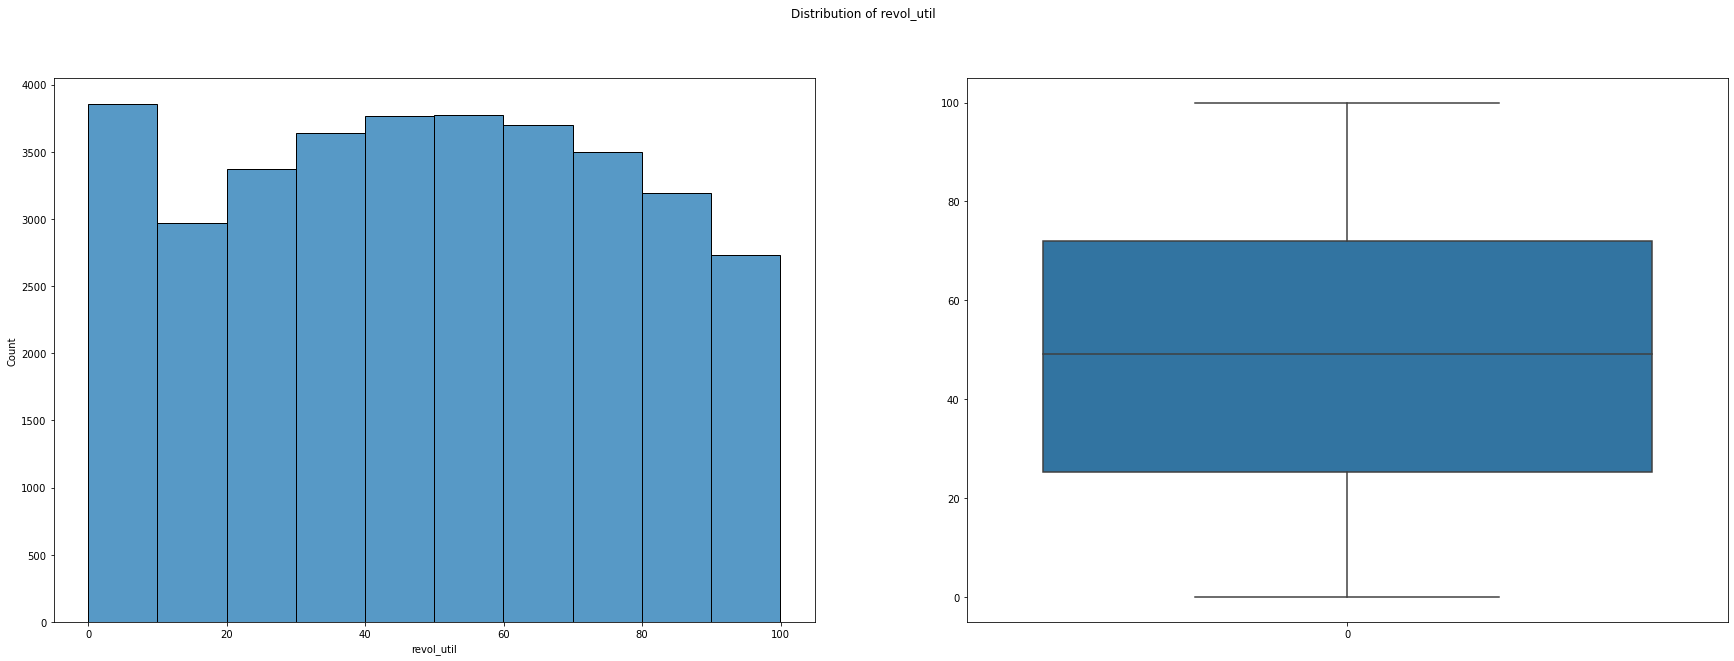

In [239]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.revol_util,bins=10)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.revol_util)
plt.suptitle('Distribution of revol_util')
plt.show()

1. 75% of borrowers had a rev utilization ratio of 72.5% and below
2. 50% of borrowers had a rev utilization ratio of 49.50% and below
3. 25% of borrowers had a rev utilization ratio of 25.6% and below
4. Histogram shows that 0 to 10% was the most utilized rev util ratio

In [240]:
df[df.loan_status=='Fully Paid']['revol_util'].describe()

count    29630.000000
mean        47.590192
std         28.143008
min          0.000000
25%         24.200000
50%         47.600000
75%         70.700000
max         99.900000
Name: revol_util, dtype: float64

In [241]:
df[df.loan_status=='Charged Off']['revol_util'].describe()

count    4857.000000
mean       55.518318
std        27.807983
min         0.000000
25%        34.400000
50%        58.500000
75%        78.800000
max        99.900000
Name: revol_util, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='revol_util'>

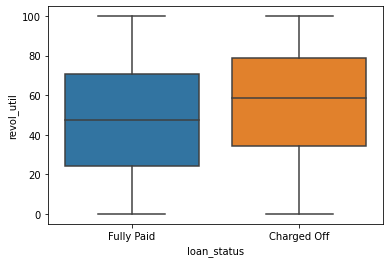

In [242]:
sns.boxplot(x='loan_status',y='revol_util',data=df)

In [243]:
z=df[['loan_status','revol_util']].value_counts().reset_index(name='count')
z.head(100)

,loan_status,revol_util,count
0,Fully Paid,0.0,703
1,Charged Off,0.0,125
2,Fully Paid,63.0,52
3,Fully Paid,40.7,49
4,Fully Paid,27.2,47
...,...,...,...
95,Fully Paid,51.5,37
96,Fully Paid,41.4,37
97,Fully Paid,51.1,37
98,Fully Paid,79.7,37


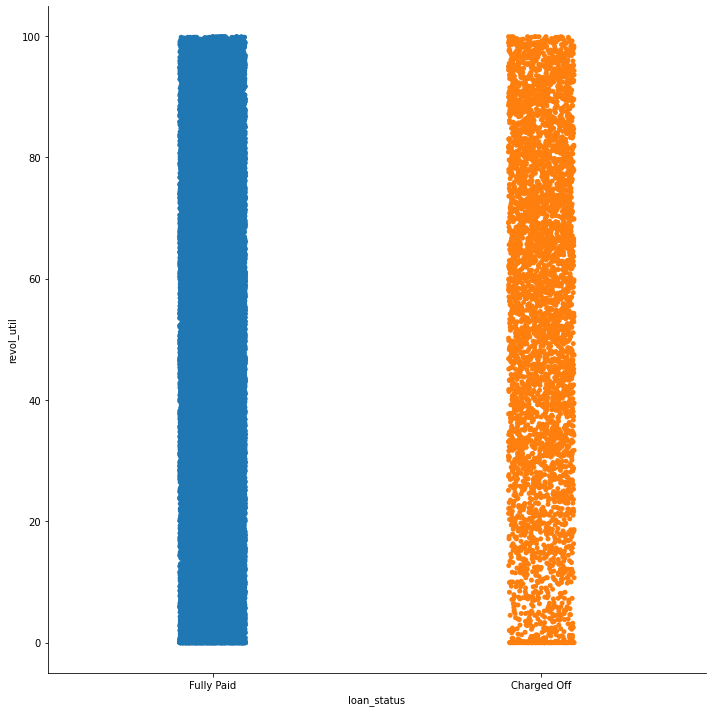

In [244]:
sns.catplot(data=df[['revol_util','loan_status']],x='loan_status',y='revol_util',size=10, aspect=1)
plt.show()

In [245]:
df['revol_util_group'] = pd.cut(df['revol_util'], bins=11,precision =0)

In [246]:
z=df[['revol_util_group','loan_status']].value_counts().reset_index(name='counts')
y=df.revol_util_group.value_counts().reset_index(name='totals').rename(columns={'index': 'revol_util_group'})
x=z.merge(y, how='left',on='revol_util_group',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '(-0.1, 9.0]'),
  Text(1, 0, '(9.0, 18.0]'),
  Text(2, 0, '(18.0, 27.0]'),
  Text(3, 0, '(27.0, 36.0]'),
  Text(4, 0, '(36.0, 45.0]'),
  Text(5, 0, '(45.0, 54.0]'),
  Text(6, 0, '(54.0, 64.0]'),
  Text(7, 0, '(64.0, 73.0]'),
  Text(8, 0, '(73.0, 82.0]'),
  Text(9, 0, '(82.0, 91.0]'),
  Text(10, 0, '(91.0, 100.0]')])

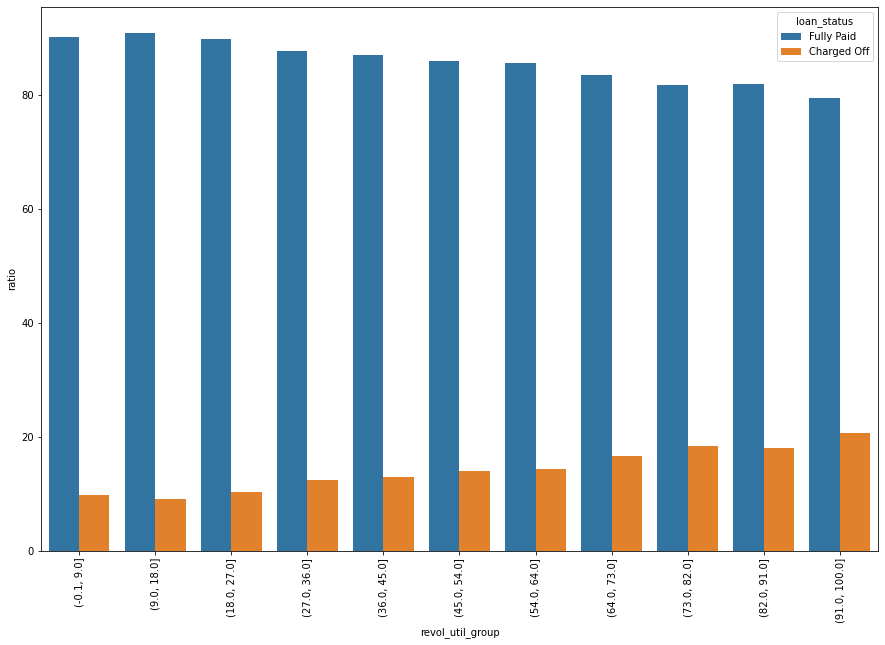

In [247]:
plt.figure(figsize=(15,10))
sns.barplot(x='revol_util_group',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation:
1. Trend shows that as rev util rate increased, the defaults increased

###earliest_cr_line

The month the borrower's earliest reported credit line/account was opened

In [248]:
df.earliest_cr_line.nunique()

508

In [249]:
df.earliest_cr_line.value_counts()

1999-10-01    343
1998-11-01    317
1998-12-01    315
1900-10-01    310
1900-11-01    300
             ... 
1965-12-01      1
1968-01-01      1
1967-06-01      1
1963-09-01      1
1972-11-01      1
Name: earliest_cr_line, Length: 508, dtype: int64

In [250]:
df['earliest_cr_line_month']=df['earliest_cr_line'].dt.month

In [251]:
df['earliest_cr_line_month'].describe()

count    34487.000000
mean         6.904805
std          3.539237
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: earliest_cr_line_month, dtype: float64

In [252]:
df.earliest_cr_line_month.mode()

0    10
Name: earliest_cr_line_month, dtype: int64

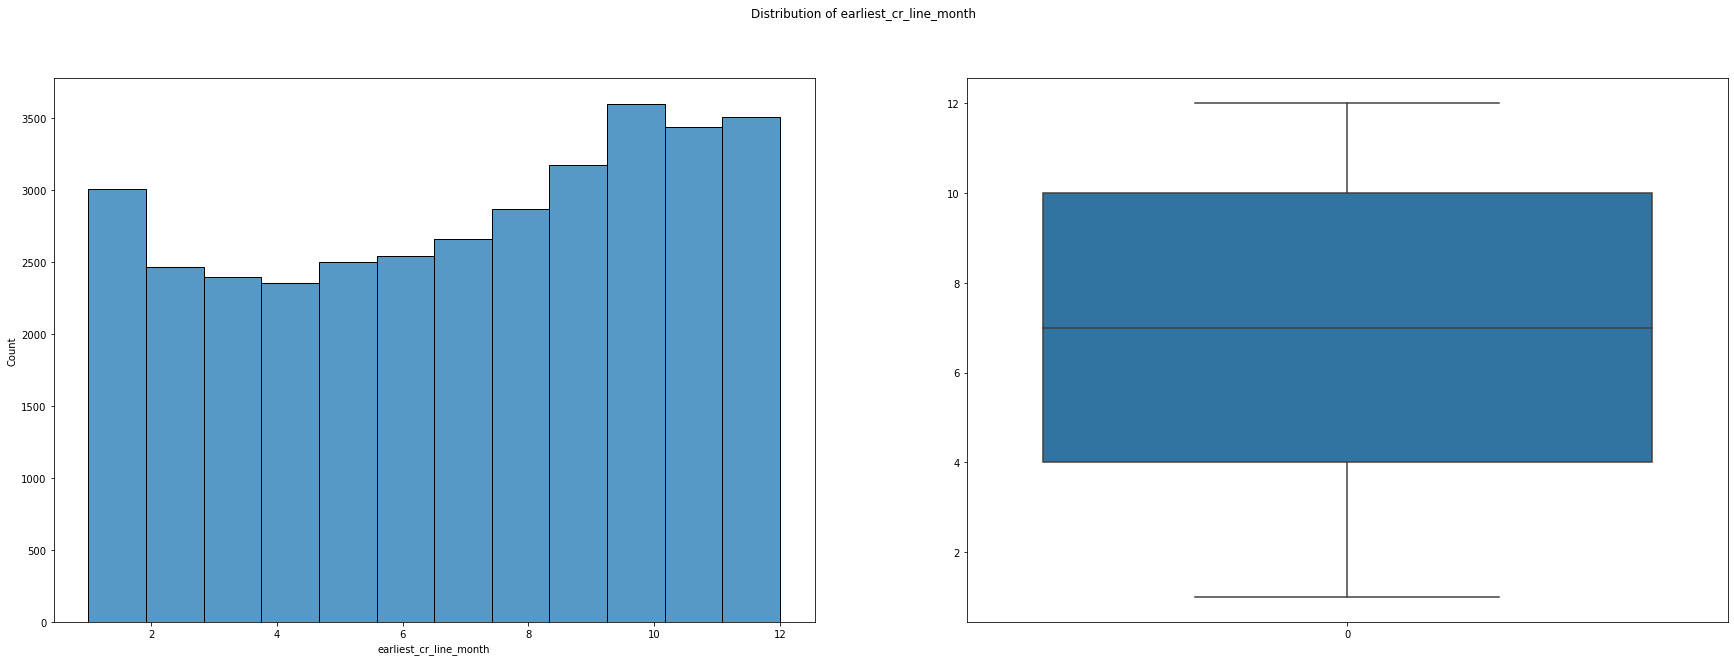

In [253]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.earliest_cr_line_month,bins=12)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.earliest_cr_line_month)
plt.suptitle('Distribution of earliest_cr_line_month')
plt.show()

1.   75% of the earliest credit lines were opened by the month end of October 
2.   50% of the earliest credit lines were opened by the month end of July
3.   25% of the earliest credit lines were opened by the month end of April
4.   No of earliest credit lines opened shows an increasing trend from the month of April. With highest in the month of October 

In [254]:
df[df.loan_status=='Fully Paid']['earliest_cr_line_month'].describe()

count    29630.000000
mean         6.936045
std          3.531089
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: earliest_cr_line_month, dtype: float64

In [255]:
df[df.loan_status=='Charged Off']['earliest_cr_line_month'].describe()

count    4857.000000
mean        6.714227
std         3.583016
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: earliest_cr_line_month, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='earliest_cr_line_month'>

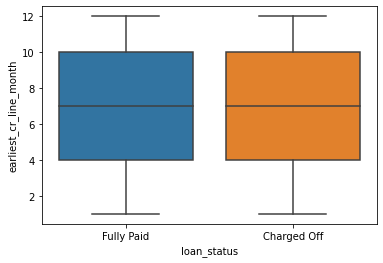

In [256]:
sns.boxplot(x='loan_status',y='earliest_cr_line_month',data=df)

In [257]:
z=df[['loan_status','earliest_cr_line_month']].value_counts().reset_index(name='count')
z.head(100)

,loan_status,earliest_cr_line_month,count
0,Fully Paid,10,3151
1,Fully Paid,11,3008
2,Fully Paid,12,2986
3,Fully Paid,9,2744
4,Fully Paid,1,2531
5,Fully Paid,8,2471
6,Fully Paid,7,2307
7,Fully Paid,6,2166
8,Fully Paid,5,2133
9,Fully Paid,2,2097


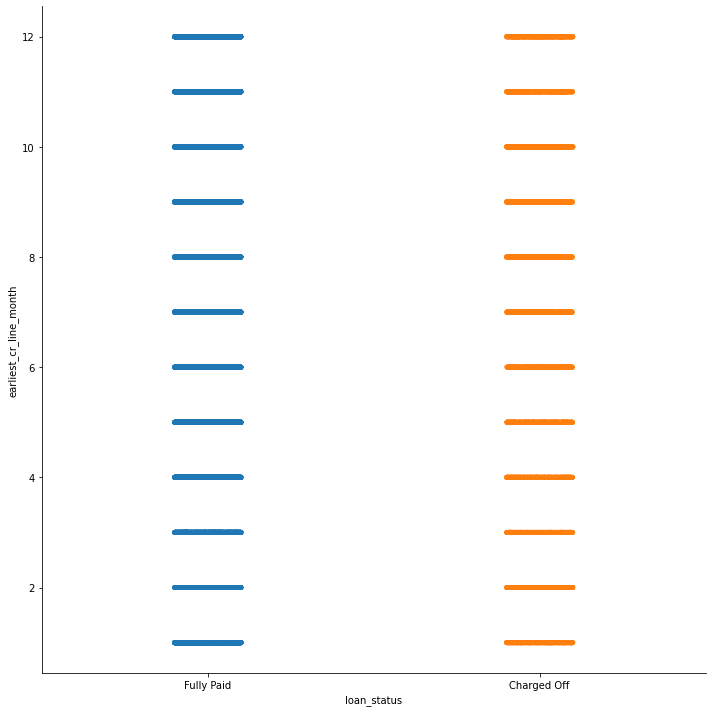

In [258]:
sns.catplot(data=df[['earliest_cr_line_month','loan_status']],x='loan_status',y='earliest_cr_line_month',size=10, aspect=1)
plt.show()

In [259]:
z=df[['earliest_cr_line_month','loan_status']].value_counts().reset_index(name='counts')
y=df.earliest_cr_line_month.value_counts().reset_index(name='totals').rename(columns={'index': 'earliest_cr_line_month'})
x=z.merge(y, how='left',on='earliest_cr_line_month',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

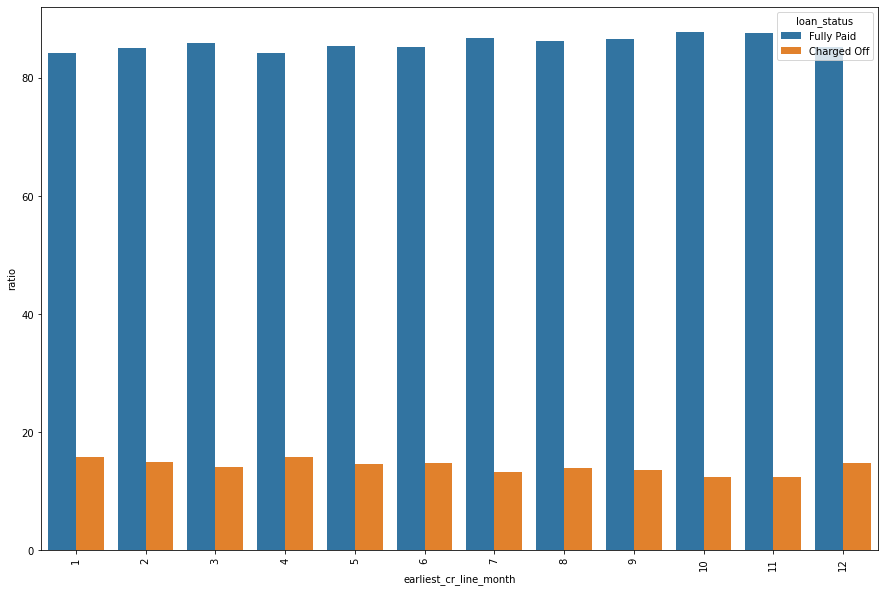

In [260]:
plt.figure(figsize=(15,10))
sns.barplot(x='earliest_cr_line_month',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation
1.   No trend observed wrt default


###last_credit_pull_month

The most recent month LC pulled credit for this loan

In [261]:
df.last_credit_pull_month.nunique()

12

In [262]:
df.last_credit_pull_month.value_counts()

5     10068
4      3751
3      2941
2      2745
12     2151
11     1984
9      1884
1      1873
10     1865
7      1832
8      1826
6      1567
Name: last_credit_pull_month, dtype: int64

In [263]:
df['last_credit_pull_month'].describe()

count    34487.000000
mean         5.845855
std          3.067200
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         12.000000
Name: last_credit_pull_month, dtype: float64

In [264]:
df.last_credit_pull_month.mode()

0    5
Name: last_credit_pull_month, dtype: int64

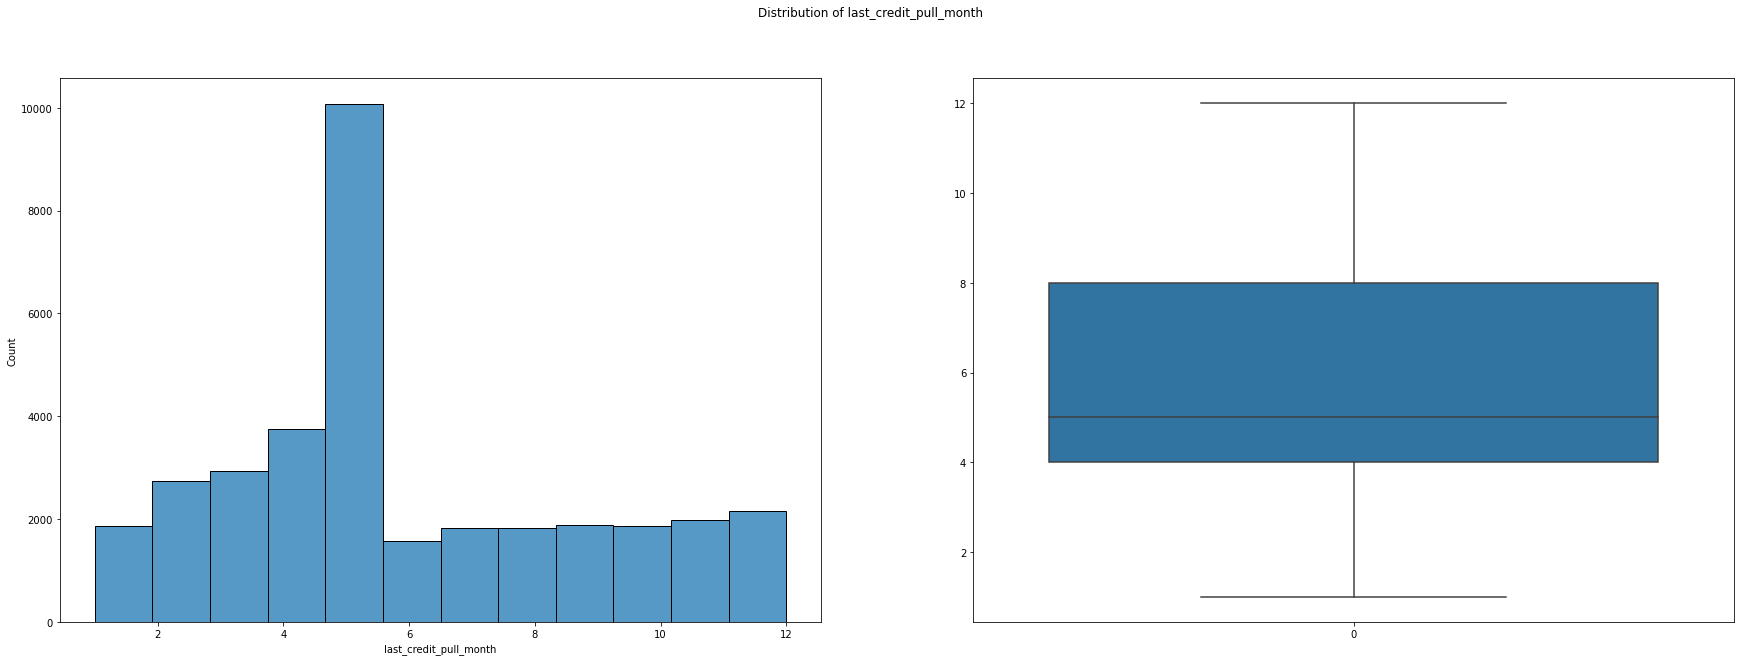

In [265]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
#Plot a histogram
sns.histplot(data=df.last_credit_pull_month,bins=12)
plt.subplot(1,2,2)
#plot a box plot
sns.boxplot(data=df.last_credit_pull_month)
plt.suptitle('Distribution of last_credit_pull_month')
plt.show()

In [266]:
df[df.loan_status=='Fully Paid']['last_credit_pull_month'].describe()

count    29630.000000
mean         5.845393
std          3.099706
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         12.000000
Name: last_credit_pull_month, dtype: float64

1.   75% of the credit pulled were by the month end of August 
2.   50% of the credit pulled were by the month end of May
3.   25% of the credit pulled were  by the month end of April
4.   No of credit pulled has an increasing trend from the month of Jan to May. With highest in the month of May. Then a sharp decline and steady frequency throughout the rest of the year 

In [267]:
df[df.loan_status=='Charged Off']['last_credit_pull_month'].describe()

count    4857.000000
mean        5.848672
std         2.861211
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        12.000000
Name: last_credit_pull_month, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='last_credit_pull_month'>

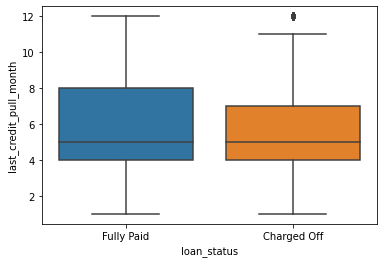

In [268]:
sns.boxplot(x='loan_status',y='last_credit_pull_month',data=df)

In [269]:
z=df[['loan_status','last_credit_pull_month']].value_counts().reset_index(name='count')
z.head(100)

,loan_status,last_credit_pull_month,count
0,Fully Paid,5,8094
1,Fully Paid,4,3247
2,Fully Paid,3,2661
3,Fully Paid,2,2416
4,Charged Off,5,1974
5,Fully Paid,12,1841
6,Fully Paid,11,1732
7,Fully Paid,1,1702
8,Fully Paid,9,1669
9,Fully Paid,10,1659


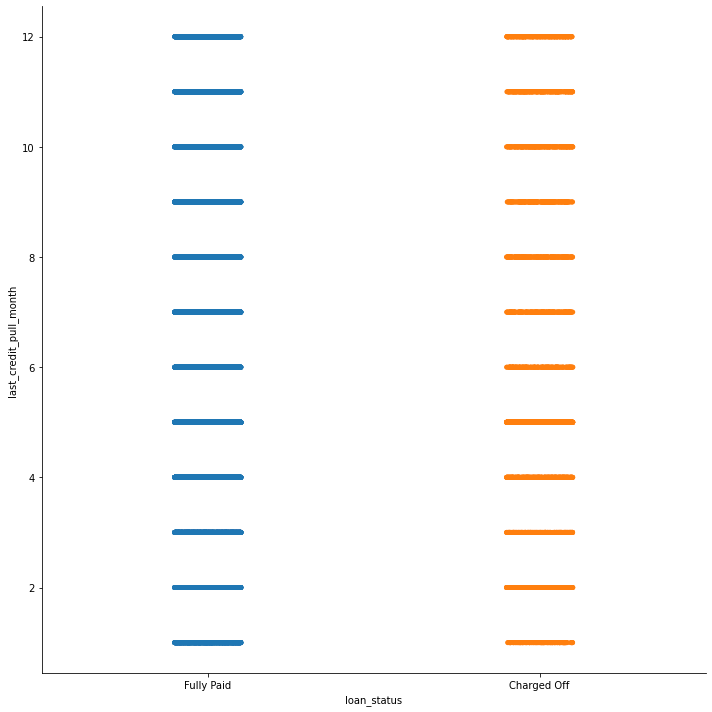

In [270]:
sns.catplot(data=df[['last_credit_pull_month','loan_status']],x='loan_status',y='last_credit_pull_month',size=10, aspect=1)
plt.show()

In [271]:
z=df[['last_credit_pull_month','loan_status']].value_counts().reset_index(name='counts')
y=df.last_credit_pull_month.value_counts().reset_index(name='totals').rename(columns={'index': 'last_credit_pull_month'})
x=z.merge(y, how='left',on='last_credit_pull_month',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

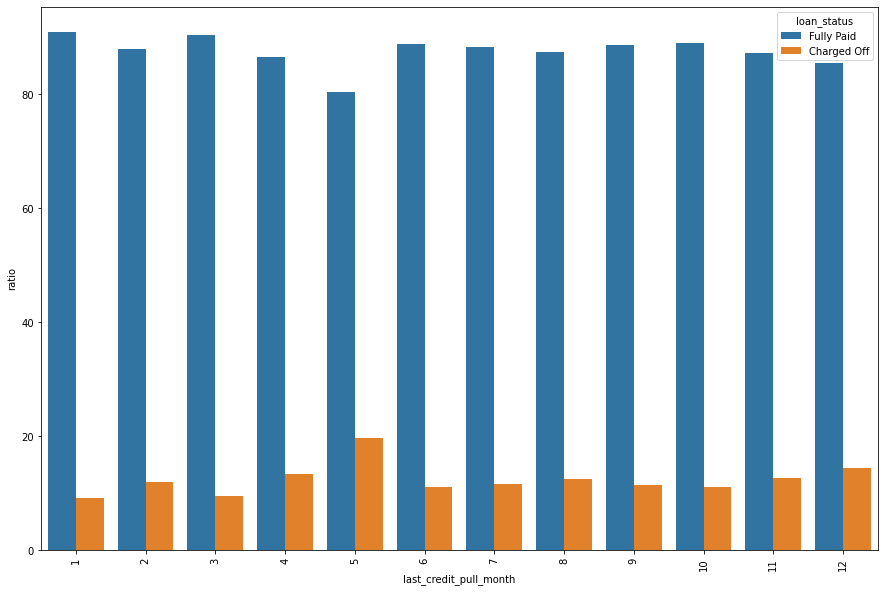

In [272]:
plt.figure(figsize=(15,10))
sns.barplot(x='last_credit_pull_month',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation

1.  Charge off seems to be the highest for the credit was pulled in the month of May





###open_acc

The number of open credit lines in the borrower's credit file.

In [273]:
df.open_acc.nunique()

40

In [274]:
df.open_acc.describe()

count    34487.000000
mean         9.157799
std          4.338305
min          2.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

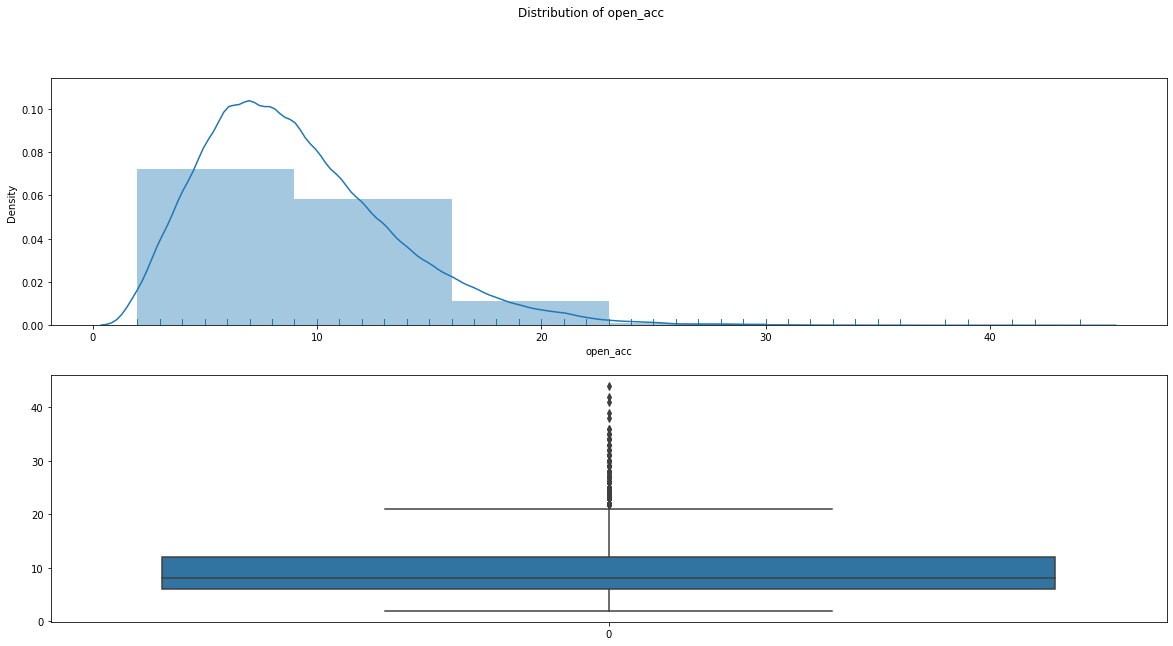

In [275]:
# ?plt.subplot takes 3 params number of rows, number of columns and index.
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#Plot a dist plot
sns.distplot(a=df.open_acc,bins=6,rug=True)
plt.subplot(2,1,2)
#plot a box plot
sns.boxplot(data=df.open_acc)
plt.suptitle('Distribution of open_acc')
plt.show()

In [276]:
df['open_acc'].quantile(0.75)-df['open_acc'].quantile(0.25) #IQR

6.0

In [277]:
df[df.loan_status=='Charged Off']['open_acc'].describe()

count    4857.000000
mean        9.112415
std         4.444251
min         2.000000
25%         6.000000
50%         8.000000
75%        12.000000
max        38.000000
Name: open_acc, dtype: float64

<AxesSubplot:xlabel='loan_status', ylabel='open_acc'>

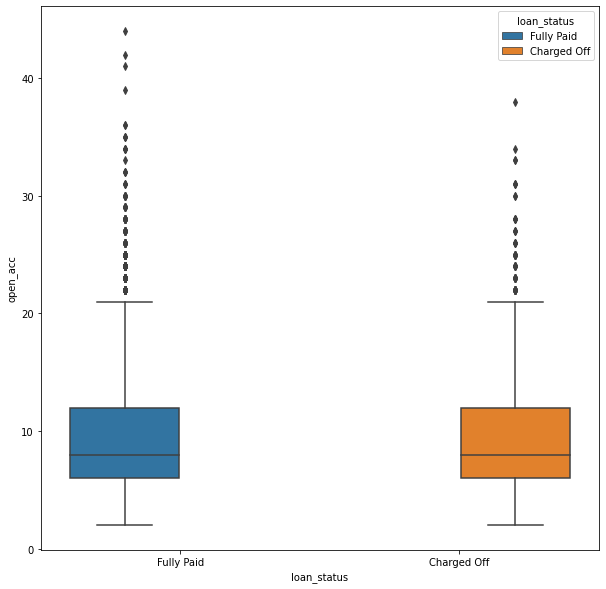

In [278]:
plt.figure(figsize=(10,10))
sns.boxplot(x='loan_status',y='open_acc',hue='loan_status',data=df)

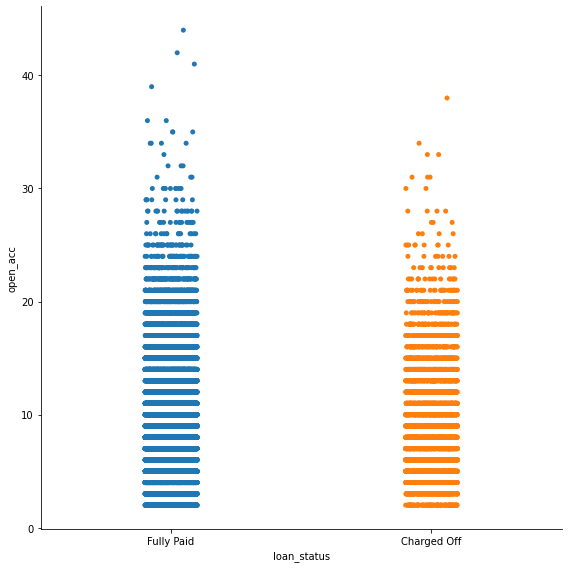

In [279]:
sns.catplot(data=df[['open_acc','loan_status']],x='loan_status',y='open_acc',size=8, aspect=1)
plt.show()

In [280]:
#https://pandas.pydata.org/docs/reference/api/pandas.cut.html
df['open_acc_group'] = pd.cut(df['open_acc'], bins=8,precision =0)

In [281]:
z=df[['open_acc_group','loan_status']].value_counts().reset_index(name='counts')
y=df.open_acc_group.value_counts().reset_index(name='totals').rename(columns={'index': 'open_acc_group'})
x=z.merge(y, how='left',on='open_acc_group',)
x['ratio']=x.apply(lambda x: (x.counts/x.totals)*100, axis = 1)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(2.0, 7.0]'),
  Text(1, 0, '(7.0, 12.0]'),
  Text(2, 0, '(12.0, 18.0]'),
  Text(3, 0, '(18.0, 23.0]'),
  Text(4, 0, '(23.0, 28.0]'),
  Text(5, 0, '(28.0, 34.0]'),
  Text(6, 0, '(34.0, 39.0]'),
  Text(7, 0, '(39.0, 44.0]')])

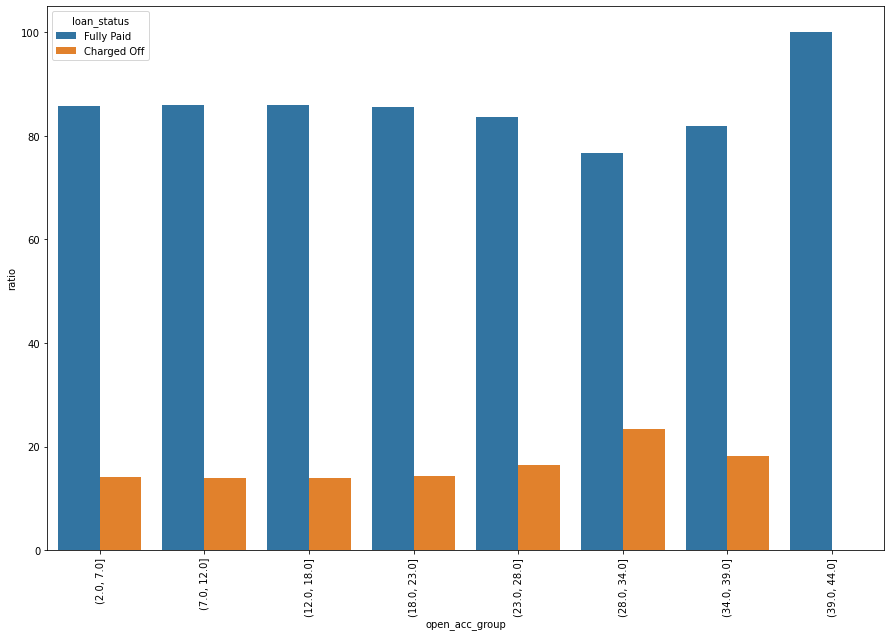

In [282]:
plt.figure(figsize=(15,10))
sns.barplot(x='open_acc_group',y='ratio', data=x,hue='loan_status')
plt.xticks(rotation=90)

Observation: 

1.   75% of borrowers had 12 or less open credit accounts
2.   50% of borowers had 9 or less open credit lines
3.   25% of borrowers had 6 or less open credit lines
4.   IQR is around 6
5.   Likelyhood of default increases if number of open lines is greater than 26



### All correlation

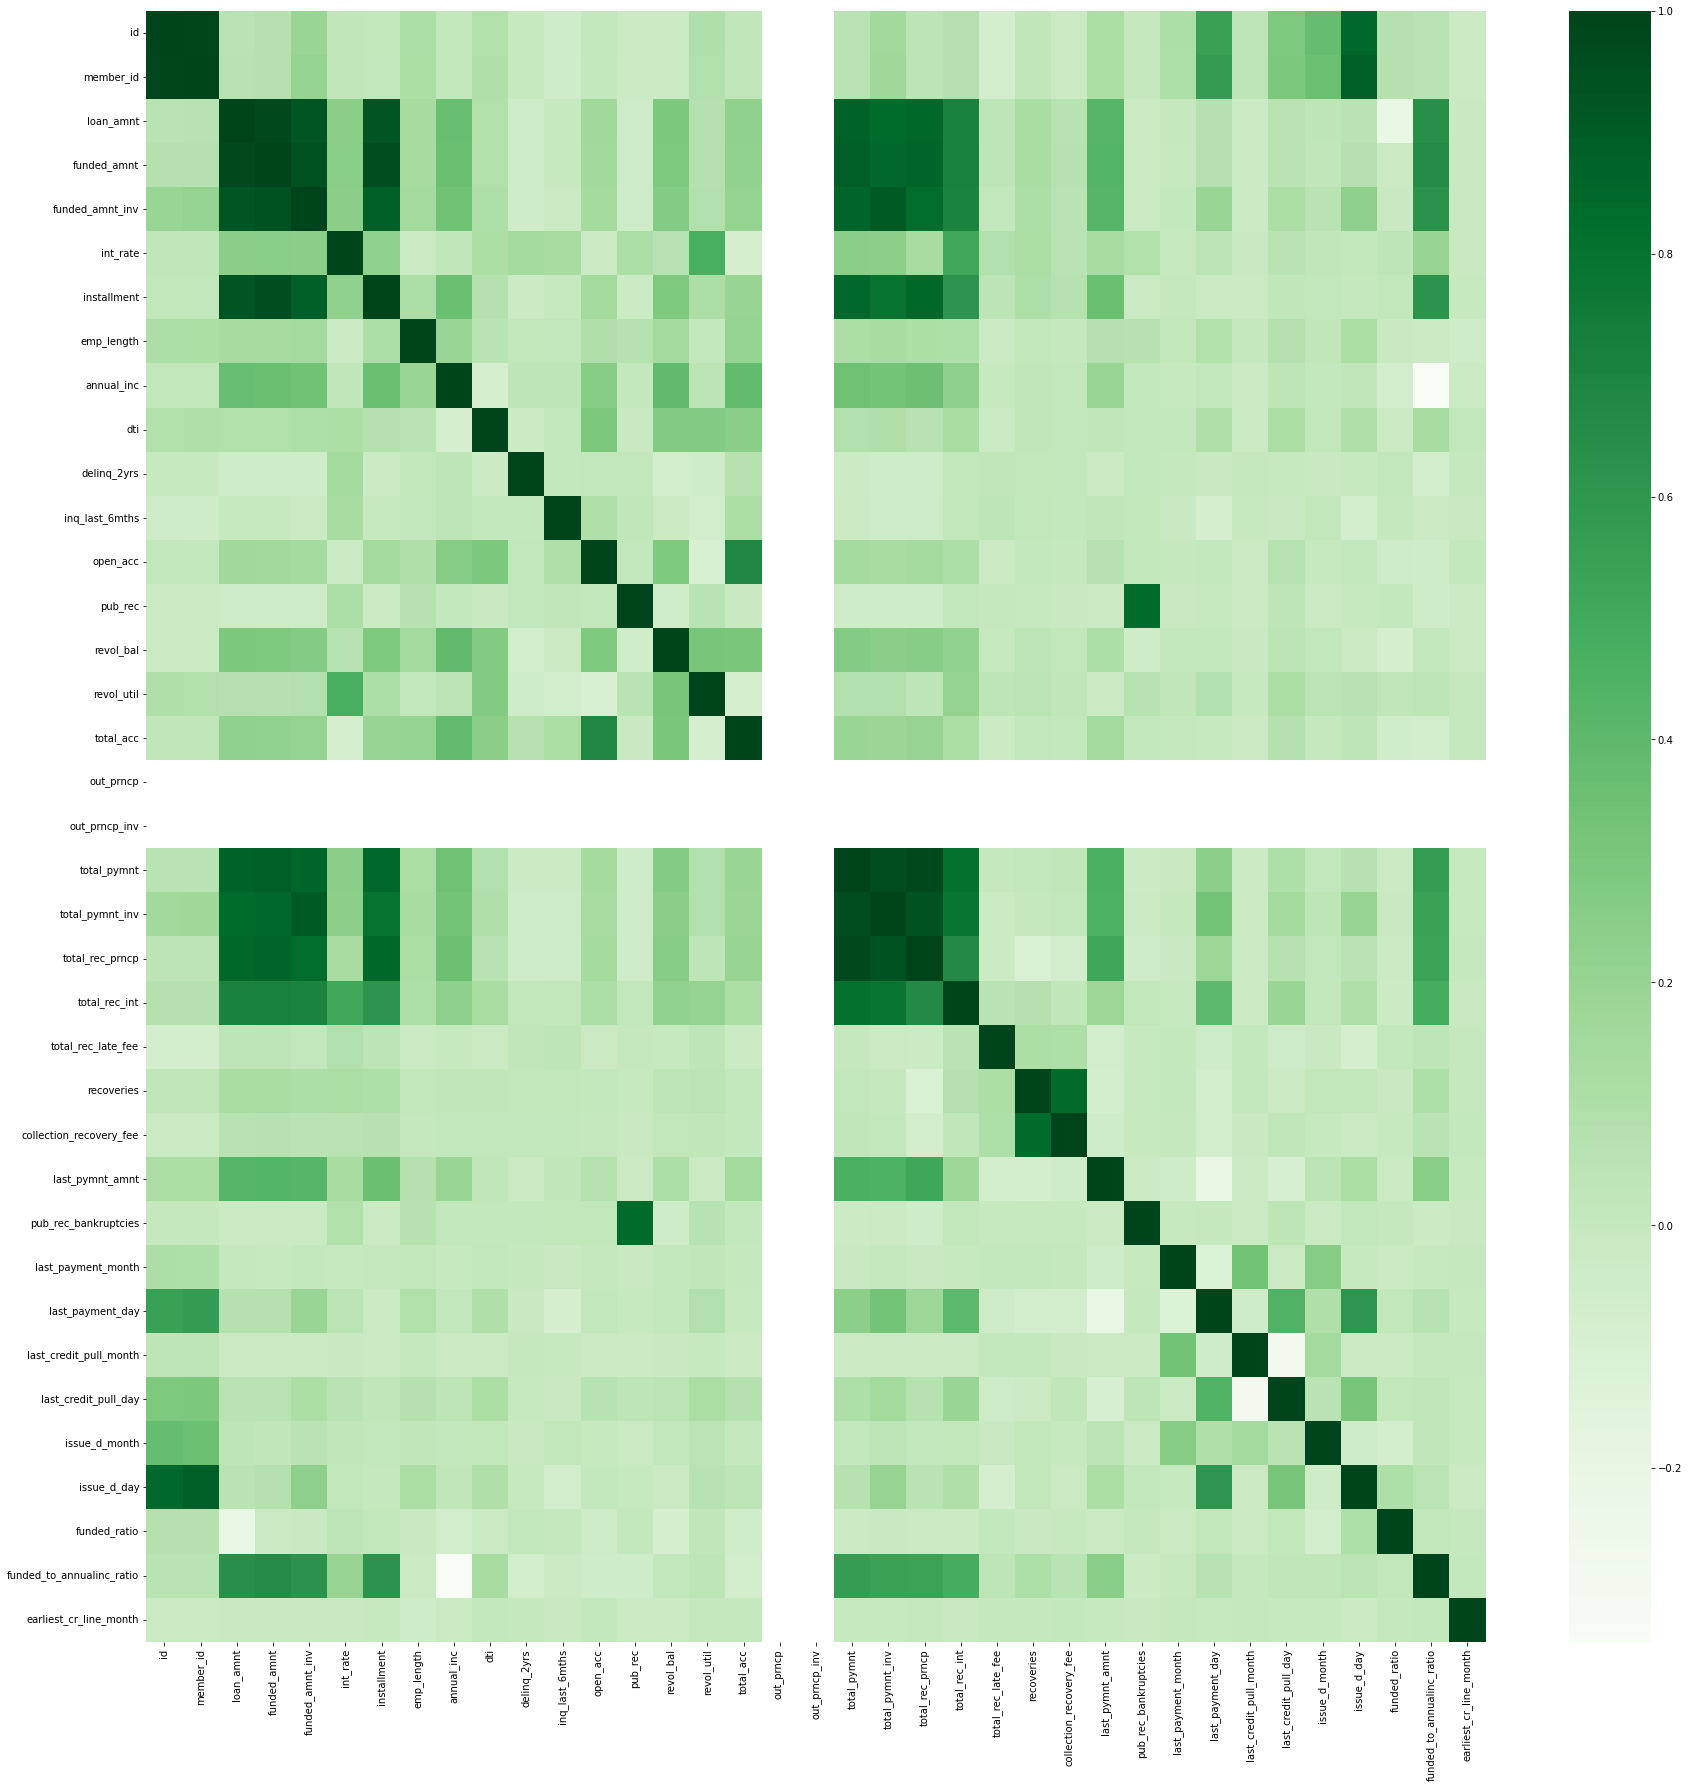

In [283]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),cmap='Greens')
plt.show()